# Ch 4. 醫療物資疫苗配送路線最佳化

本作業以「醫療物資與疫苗配送」為應用情境，讓同學透過多種演算法解決 旅行推銷員問題（TSP, Traveling Salesman Problem），體驗如何將理論演算法應用於實際醫療物流的最佳化問題。完成本作業後，你將能夠：

1. 實作並比較四種最佳化方法（窮舉法、動態規劃法、最近鄰居法、基因演算法）
2. 以圖表與數據分析不同演算法的特性與效率差異
3. 反思演算法於真實醫療配送場景中的應用與限制

## Section 0. 預備知識與資料準備

拿到資料第一件事情，就是要載入資料

In [27]:
import pandas as pd
df_hospital = pd.read_csv("hospitals.csv")
df_hospital.head()

,x,y
0,0.0,9.3
1,34.8,67.3
2,53.2,100.0
3,42.2,59.6
4,30.7,37.9


這很明顯就是地圖座標，但是看表格實在不好操作，所以就把這些點印在 scatter plot 上面

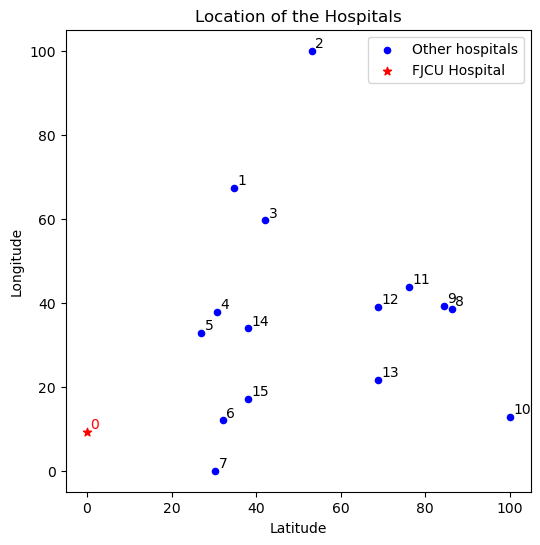

In [28]:
import matplotlib.pyplot as plt

x, y = df_hospital.iloc[1:][["x"]], df_hospital.iloc[1:][["y"]]
x_0, y_0 = df_hospital.loc[0, "x"], df_hospital.loc[0, "y"]

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title("Location of the Hospitals")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.scatter(x, y, s=20, color="blue", label="Other hospitals")
ax.scatter(
    x_0,
    y_0,
    color="red",
    marker="*",
    zorder=5,
    label="FJCU Hospital",
)

for index, row in df_hospital.iterrows():
    text_color = "red" if index == 0 else "black"
    ax.text(
        row["x"] + 0.8,
        row["y"] + 0.8,
        str(index),
        fontsize=10,
        ha="left",
        color=text_color,
    )

ax.legend()
plt.show()

現在陽春地圖已經有了，所以可以進入四種演算法的實作

## Section 1. Exhaustive Search

> _嘗試以窮舉方式找出最短路徑。若計算量過大、無法在合理時間內完成，請估算理論上所需的計算次數與時間，並討論其可行性_

### Step A. Time Complexity

窮舉法（Exhaustive Search）可以說是最暴力破解的方法之一，對於「從原點出發找另外 15 個點路徑數量」題目，是經典的排列組合問題，理論上會存在 $15! = 1,307,674,368,000$ 個路徑。現在問題在於要如何透過 loop 來迭代出這 $15!$ 個路徑、並且在每一條路徑中加入起點來計算總距離？

但換個角度想，問題並不在於「要如何迭代」，而是因為計算效率的問題。針對這類 TSP 的窮舉解法的時間複雜度為 $O((N-1)!)$ 或 $O(N!)$，屬於階乘時間（Factorial Time），在時間效率上可以說是難以實現。思考一次 Euclidean 距離 $d = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$ 就包含兩次減法、兩次乘法、一次加法、還有一次平方根運算。這之外，還需要執行 $15!$ 次的距離計算，這運算量可想而知非常大。以下是透過 NumPy 進行矩陣運算的程式碼：

In [29]:
# import itertools
# import time
# import numpy as np
# from scipy.spatial.distance import cdist

# # 1. Permutation
# A = df_hospital[["x", "y"]].values
# D = cdist(A, A, metric="euclidean")
# H = list(range(1, 16))
# P_gen = itertools.permutations(H)
# d_min = float("inf")
# p_min = []
# c = 0

# # 2. Exhaustive Search
# t_start = time.perf_counter()

# for p in P_gen:
#     # NumPy array for indexing
#     p_curr = np.array([0] + list(p) + [0])
#     idx_a = p_curr[:-1]  # from
#     idx_b = p_curr[1:]  # to
#     d_curr = D[idx_a, idx_b].sum()

#     # find best dist
#     if d_curr < d_min:
#         d_min = d_curr
#         p_min = list(p_curr)
#     c += 1

#     # Print progress update per 1 billion paths
#     if c % 1_000_000_000 == 0:
#         t_elapsed = time.perf_counter() - t_start
#         print(f"Checked {c // 1_000_000_000} billion paths... (Time: {t_elapsed:.2f}s)")

在 Apple Mac Mini M4 晶片下進行操作，實際執行得出

```text
Checked 1 billion paths... (Time: 1852.93s)
Checked 2 billion paths... (Time: 3691.76s)
Checked 3 billion paths... (Time: 5538.67s)
Checked 4 billion paths... (Time: 7397.20s)
Checked 5 billion paths... (Time: 9265.18s)
Checked 6 billion paths... (Time: 11123.56s)
Checked 7 billion paths... (Time: 13012.56s)
Checked 8 billion paths... (Time: 14901.73s)
Checked 9 billion paths... (Time: 16784.20s)
```

實際執行 90 億次路徑的總消耗時間為 $16784.20$ 秒。可以計算出平均每 10 億路徑的消耗時間 $t_{b,\text{avg}}$

$$
t_{b,\text{avg}} = \frac{16784.20 \text{ sec}}{9 \text{ intervals}} \approx 1864.91 \text{ sec/interval}
$$

使用這個平均速率 $R_{\text{avg}}$ 來推估總執行時間 $T$：

$$
R_{\text{avg}} = \frac{1,000,000,000 \text{ paths}}{1864.91 \text{ s}} \approx 536,218 \text{ paths/second}
$$

總執行時間 $T$ 為：

$$
\begin{aligned}
T &= \left(\frac{N}{b}\right) \times t_{b,\text{avg}} \\
&= \left(\frac{1,307,674,368,000}{1,000,000,000}\right) \times 1864.91 \text{ sec} \\
&\approx 1307.674 \times 1864.91 \text{ sec} \\
&\approx 2,438,820 \text{ sec}
\end{aligned}
$$

時間換算下來大約是 28.23 天左右，在實務上根本不可行。那會導致這情況的根本原因，在於 TSP 問題本身就是 NP-Complete 的問題。在 _Step B_ 中會使用數學的形式說明為何 TSP 是 NP-Complete，因此窮舉法難以進行

### Step B. TSP is NP Complete

有關圖論相關基礎知識，可以參考這篇在 Medium 論壇上的文章 [離散數學學習筆記：圖論（Graph Theory）](https://medium.com/@ralph-tech/離散數學學習筆記-圖論-graph-theory-f2241cc1134a)。那來回頭思考原問題：

> 從原點出發找另外 15 個點路徑數量以找出最短路徑

這份作業的第一部分本身就是一個 Traveling Salesman 問題（以下簡稱 TSP），而其基底結構是 Hamilton Circuit，用來判斷一個圖 $G$ 是否存在一條 **每個節點只走過一次** 的回路：

> 給定加權圖 $G$ 中，是否存在一條總權重小於或等於 $k$ 的 Hamilton Circuit？

現在這些數學定義可以描述出 TSP 問題的圖論結構，以及該問題的形式化定義。那 Karp (1972) 有明確將 Hamilton Circuit 列為 NP-Complete 的問題之一 [1]；而 Garey & Johnson (1979) 在 _Section 2.3 Nondeterministic Computation and the Class NP_ 中直接證明 TSP 屬於 NP-hard。換句話說，就是在多項式時間內如 $O(N^2)$ 或 $O(N^3)$ 等，無法解決所有 TSP 實例的演算法，因此證明 $O(N!)$ 窮舉法本身就相當沒有效率 [2]

有關資料結構（或離散數學）中的圖論如何對應到這個 TSP 問題，可參考以下說明

#### Step B.1 Formal Definitions

##### Definition 0. NP-Hard and NP-Complete

計算複雜度類別 $\text{NP}$ 與 $\text{NP-Complete}$ 的形式化定義，來自於 **Cook (1971) [1]** 及其與 **Levin (1973) [2]** 的獨立發現。令 $L, L_C$ 為語言（Languages），則

1. $L$ 被定義為 NP-Hard，若且唯若所有 $\text{NP}$ 中的語言 $L'$ 都能在多項式時間內歸約至 $L$：

    $$
    L \in \text{NP-Hard} \iff (\forall L' \in \text{NP}, L' \le_P L)
    $$

2. 一個基於歸約傳遞性的等價定義是：$L$ 為 NP-Hard，若且唯若 **存在** 一個 NP-Complete 語言 $L_C$ 使得 $L_C \le_P L$，寫為

    $$
    L \in \text{NP-Hard} \iff (\exists L_C \in \text{NP-Complete} \text{ s.t. } L_C \le_P L)
    $$

3. $L$ 被定義為 NP-Complete，若且唯若 (i) $L \in \text{NP}$ 且 (ii) $L$ 是 NP-Hard。

    $$
    L \in \text{NP-Complete} \iff (L \in \text{NP}) \land (L \in \text{NP-Hard})
    $$

##### Definition 1. Graph

一個圖（Graph） $G$ 是一個序列組合 $(V, E)$，其中 $V$ 是一個有限的節點集合、而 $E \subseteq \{\{u, v\} \mid u, v \in V, u \neq v\}$ 是一個邊（edge）的集合 

$\blacksquare$

##### Definition 2. Undirected Hamiltonian Circuit (UHC)

令 $G = (V, E)$ 為一個 $n$ 節點的圖。一個 UHC 是 $V$ 的一個排列 $\pi = \langle v_1, v_2, \dots, v_n \rangle$，滿足邊的條件如下：

$$
\{v_n, v_1\} \in E \quad \land \quad \forall i \in \{1, \dots, n-1\}, \{v_i, v_{i+1}\} \in E
$$

此處 $\pi$ 是 $V$ 的一個排列，已隱含 $\pi$ 是一個包含 $V$ 中所有節點、長度為 $n$、且所有元素互不相同的序列

$\blacksquare$

##### Definition 3. STSP Instance: Weighted Complete Graph

一個 $n$ 節點的 TSP 實例是一個序列組合 $(V, w)$，其中：
1. $V$ 是一個包含 $n$ 個節點的有限集合
2. $w: E_K \to \mathbf{R}^+$ 是一個權重函數，其定義域 $E_K$ 是基於 $V$ 的完全圖 $K_n$ 的邊集合

$\blacksquare$

簡單來說，TSP 的解是一個 Hamiltonian Cycle，也就是一個走訪 $N$ 個節點，最後回到起點的 閉合路徑。因此可以寫出以下定義來說明路徑如何做到最佳化

##### Definition 4. STSP Optimization

令 $(V, w)$ 為一個如 Definition 3 所述的 STSP 問題；令 $\Pi_V$ 為 $V$ 上所有 UHC 的集合。而 STSP 最佳化問題的是找到一個排列 $\pi^* \in \Pi_V$ 使得其總路徑權重 $W(\pi^\ast)$ 有最小值：

$$
\begin{aligned}
W(\pi) &:= \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) \\
\pi^* &:= \arg\min_{\pi \in \Pi_V} W(\pi)
\end{aligned}
$$

$\blacksquare$

由於路徑 $\langle v_1, \dots, v_n \rangle$ 與 $\langle v_n, \dots, v_1 \rangle$ 總距離相同，STSP 的搜尋空間 $\Pi_V$ 實際上是 $(N-1)!/2$。但對於 $O(N!)$ 窮舉法分析，使用 $(N-1)!$ 或 $N!$ 在複雜度級別上是相同的。這個過程就是透過數學方法，將這次題目中的 TSP 用形式化的方式寫成 UHC

##### Definition 5. The Traveling-Salesperson Decision Problem `TSP-DECISION`

`TSP-DECISION` 在數學上寫成 $L_{\text{TSP}}$ ，是所有 STSP 問題 $(V, w)$ 與邊界 $k$ 的編碼 $\langle (V, w), k \rangle$ 的集合，其中 $k \in \mathbf{R}$，且存在一個 UHC $\pi \in \Pi_V$ 滿足 $W(\pi) \le k$。寫為：

$$L_{\text{TSP}} := \{ \langle (V, w), k \rangle \mid \exists \pi \in \Pi_V \text{ s.t. } W(\pi) \le k \}$$

$\blacksquare$

#### Step B.2 Inducing TSP-DECISION is NP-Complete

Cormen et al. (2022) 在 _Section 34.5.4 "The traveling-salesperson problem"_ 中，在技術上是證明 **無向** 對稱 TSP 的 NP-hard 的問題 [5]

##### Lemma 1. Membership of TSP-DECISION in NP

令 $L_{\text{TSP}}$ 為 _Definition 5_ 中定義的 TSP-DECISION 語言，則 $L_{\text{TSP}} \in \text{NP}$

**【Proof】**

若要證明 $L_{\text{TSP}} \in \text{NP}$，則需要建立一個多項式時間的驗證機制 $V$，其中

- 一個 STSP 實例 $\langle (V, w), k \rangle$ 及一個 certificate $\pi$
- $V$ 中 $n$ 個節點的排列 $\pi = \langle v_1, v_2, \dots, v_n \rangle$

而$V$ 需要操作以下演算法：

1. 驗證 $\pi$ 是 $V$ 的有效排列 (Time: $O(n \log n)$ or $O(n)$)
2. 計算總權重 $W(\pi) := \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\})$ (Time: $O(n)$)
3. 檢查 $W(\pi) \le k$ (Time: $O(1)$)

$V$ 的總執行時間為 polynomial time（以 $n = |V|$ 為界）。若 1 到 3 均成立，則驗證機制接受該輸入。這時因為存在一個多項式時間的驗證機制，故 $L_{\text{TSP}} \in \text{NP}$ 成立 $\blacksquare$

##### Lemma 2. NP-Hardness of TSP-DECISION

令 $L_{\text{TSP}}$ 為 _Definition 5_ 中定義的 TSP-DECISION 語言

**【Proof】**

若要證明 $L_{\text{TSP}}$ 為 NP-Hard，則需要寫出已知的 NP-Complete 語言 $L_{\text{HAM}}$ 可在多項式時間內歸約至 $L_{\text{TSP}}$

- 使用已知的 NP-Complete 語言 $L_{\text{HAM}}$ (Karp, 1972)，定義為

    $$
    L_{\text{HAM}} := \{ \langle G \rangle \mid G=(V, E) \text{ is an undirected graph containing a Hamiltonian circuit} \}
    $$

- 建立一個多項式時間函數 $f$，將 $L_{\text{HAM}}$ 問題 $\langle G \rangle$ 映射到 $L_{\text{TSP}}$ 問題 $\langle (V, w), k \rangle$。則 $f$ 的構造演算法可以令 $\langle G=(V, E) \rangle$ 為輸入、$\langle (V', w), k \rangle$ 為輸出；令 $V' = V$ 且 $k = 0$。則 $\forall \{u, v\} \subseteq V$，定義權重函數 $w$：$$w(\{u, v\}) = \begin{cases} 0 & \text{if } \{u, v\} \in E \\ 1 & \text{if } \{u, v\} \notin E \end{cases}$$

此歸約 $f$ 的執行時間為 $O(|V|^2)$（用於建立 $w$），為多項式時間。必須證明 $\langle G \rangle \in L_{\text{HAM}} \iff f(\langle G \rangle) \in L_{\text{TSP}}$

1.  **Forward Implication ($\implies$)**

    **假設 $\langle G \rangle \in L_{\text{HAM}}$**

    $$ 
    \begin{aligned}
        & \langle G \rangle \in L_{\text{HAM}} \\
        \implies \quad & (\exists \text{ UHC } \pi = \langle v_1, \dots, v_n \rangle \text{ in } G) & & \text{; Definition of } L_{\text{HAM}} \\
        \implies \quad & (\forall i \in [1, n-1], \{v_i, v_{i+1}\} \in E) \land (\{v_n, v_1\} \in E) & & \text{; Definition 2 (UHC)} \\
        \implies \quad & (\forall i \in [1, n-1], w(\{v_i, v_{i+1}\}) = 0) \land (w(\{v_n, v_1\}) = 0) & & \text{; Definition of } w \text{ in reduction } f \\
        \implies \quad & W(\pi) = \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) = 0 & & \text{; Definition 4 (STSP)} \\
        \implies \quad & W(\pi) \le 0 & & \text{; Since } k=0 \text{ in reduction } f \\
        \implies \quad & \langle (V, w), 0 \rangle \in L_{\text{TSP}} & & \text{; Definition 5 (TSP-DECISION)}
    \end{aligned}
    $$

2.  **Backward Implication ($\impliedby$)**

    假設 $\langle (V, w), 0 \rangle = f(\langle G \rangle) \in L_{\text{TSP}}$

    $$  
    \begin{aligned}
        & \langle (V, w), 0 \rangle \in L_{\text{TSP}} \\
        \implies \quad & (\exists \text{ UHC } \pi = \langle v_1, \dots, v_n \rangle \text{ s.t. } W(\pi) \le 0) & & \text{; Definition 5 (TSP-DECISION), with } k=0 \\
        \implies \quad & \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) \le 0 & & \text{; Definition 4 (STSP)} \\
        \implies \quad & (\forall \{u,v\}, w(\{u,v\}) \ge 0) \land (W(\pi) \le 0) & & \text{; Definition of } w \text{ (non-negative)} \\
        \implies \quad & (\forall i \in [1, n-1], w(\{v_i, v_{i+1}\}) = 0) \land (w(\{v_n, v_1\}) = 0) & & \text{; Sum of non-negatives is $\le 0$ iff all terms are $0$} \\
        \implies \quad & (\forall i \in [1, n-1], \{v_i, v_{i+1}\} \in E) \land (\{v_n, v_1\} \in E) & & \text{; Definition of } w \text{ in reduction } f \\
        \implies \quad & \pi \text{ is a UHC} \in G & & \text{; Definition 2 (UHC)} \\
        \implies \quad & \langle G \rangle \in L_{\text{HAM}} & & \text{; Definition of } L_{\text{HAM}}
    \end{aligned}
    $$

$\blacksquare$

##### Theorem 1. NP-Completeness of TSP-DECISION

令 $L_{\text{TSP}}$ 為 _Definition 5_ 中定義的 TSP-DECISION 語言，寫為

$$
L_{\text{TSP}} \in \text{NP-Complete}
$$

**【Proof】**

根據 _Lemma 1_，得 $L_{\text{TSP}} \in \text{NP}$；而根據 _Lemma 2_，得 $L_{\text{TSP}} \in \text{NP-Hard}$。
根據 NP-Complete 的定義，一個語言 $L$ 若滿足 $L \in \text{NP}$ 且 $L \in \text{NP-Hard}$，則 $L \in \text{NP-Complete}$

因此，$L_{\text{TSP}} \in \text{NP-Complete}$ $\blacksquare$

##### Proposition 1. NP-Hardness of STSP Optimization

_Definition 4_ 中定義的 STSP 最佳化問題屬於 NP-Hard

**【Proof】** 

假設 STSP 最佳化問題能被一個多項式時間演算法 $A$ 解決，其中 $A$ 回傳 $\pi^*$ 及其權重 $W(\pi^*)$。那可建立一個多項式時間演算法來解決 _Theorem 1_ 中的 NP-Complete 問題 $L_{\text{TSP}}$，即：

給定 $L_{\text{TSP}}$ 實例 $\langle (V, w), k \rangle$，執行 $A$ 於 $(V, w)$ 在多項式時間內獲得 $W(\pi^*)$。若 $W(\pi^*) \le k$，則接受；否則拒絕。由於根據 _Lemma 2_，可以知道 $L_{\text{TSP}}$ 是 NP-Hard；再根據 _Definition 0_ 得知 STSP 最佳化問題也是 NP-Hard $\blacksquare$

### Step C. Feasibility of GPU Operation?

如前所述，GPU 平行化 $O(N!)$ 窮舉法需要一個「排列解碼 (Permutation Unranking)」演算法（通常基於 Lehmer Code）。在此架構下，CUDA 的每個執行緒 ID（例如 0 到 $15!-1$）必須獨立計算出它對應的唯一排列，然後再計算該排列的距離。

學術界普遍認為 GPU 窮舉 TSP 不切實際，例如，參考 Myrvold, W., & Ruskey, F. (2001) 提到 GPU 執行緒 $i$ 需要執行的 `get_permutation(i, N)` 操作（在學術上稱為 Unranking），即使是 $O(N)$ 的演算法 [6]

而其中每個執行緒 $i$ 在計算 $W(\pi_i)$ 時，仍需存取 GPU 全域記憶體 $O(N)$ 次。StackOverflow 文章 [Generating permutations with CUDA](https://stackoverflow.com/questions/19945347/generating-permutations-with-cuda) 有針對 CUDA 的運算，提到

> 需要為每個執行緒實作一個 unranking 函數，因為其將執行緒索引轉換為一個唯一的排列

當數千個 CUDA 核心同時執行 $O(N)$ 次非連續（non-coalesced）的記憶體存取時，底層的記憶體匯流排 (Bus) 是非常「混亂」的

在 Map 階段， $1.3 \times 10^{12}$ 個執行緒各自計算一個距離。在 Reduce 階段，你需要找到這些距離中的最小值。如果每個距離（$d_i$）使用 32-bit 浮點數（4 bytes）儲存，則儲存所有中間結果需要 

$$
1.308 \times 10^{12} \times 4 \text{ bytes} \approx 5.23 \times 10^{12} \text{ bytes} \approx \mathbf{5.23 \text{ TB}}
$$

另外，根據市面上常見顯示卡，以 workstation 等級的 96GB VRAM 中，也無法儲存 5.23 TB 的執行結果。這時必須將 $1.3 \times 10^{12}$ 的工作拆分成數百萬個 batches 執行，然後在 GPU 上執行極其複雜的平行歸約（Parallel Reduction）出每個 batch 的最小值，在回傳到 CPU 進行比較。這在硬體底層的執行流程，會遠比單純的 $O(N!)$ 迴圈複雜

### Citation

[1] Karp, R. M. (1972). Reducibility among Combinatorial Problems. In: Miller, R.E., Thatcher, J.W., Bohlinger, J.D. (eds) _Complexity of Computer Computations._ The IBM Research Symposia Series. Springer, Boston, MA. https://doi.org/10.1007/978-1-4684-2001-2_9

[2] M. R. Garey and D. S. Johnson, _Computers and Intractability: A Guide to the Theory of NP-Completeness_. W. H. Freeman and Company, 1979.

[3] Cook, S. A. (1971). The complexity of theorem-proving procedures. In _Proceedings of the third annual ACM symposium on Theory of computing (STOC '71)_ (pp. 151–158). Association for Computing Machinery. https://doi.org/10.1145/800157.805047

[4] L. A. Levin, “Universal sequential search problems,” _Problems of Information Transmission_, vol. 9, no. 3, pp. 265–266, 1973. (Source from https://doi.org/10.1134/11122.1608-3253)

[5] T. H. Cormen, C. E. Leiserson, R. L. Rivest, and C. Stein, _Introduction to Algorithms_, 4th ed. MIT Press, 2022.

[6] Myrvold, W., & Ruskey, F. (2001). Ranking and unranking permutations in linear time. _Information Processing Letters_, 79(6), 281–284. https://doi.org/10.1016/S0020-0190(01)00141-7

## Section 2. Dynamic Programming, DP

由於在 _Section 1_ 窮舉法的 $O(N!)$ 時間複雜度，讓計算時間到達 28 天左右，這時候就需要另外一個較為可行的辦法

### Step A. Bellman-Held-Karp Algorithm

#### Step A.1 Foundation

Bellman, R. (1962) 在三頁論文中，就提出動態規劃求解 TSP 的基礎，作者假設存在從城市 0 開始的最佳路徑，定義 $d_{ij}$ 為城市 $i$ 和城市 $j$ 之間的距離；函數 $f(i; j_1, j_2, \dots, j_k)$ 是從城市 $i$ 出發，走訪集合 $\{j_1, \dots, j_k\}$ 中每個城市各一次，最後回到起點 0 的最短路徑長度。根據最佳化定理，要計算 $f(i; j_1, \dots, j_k)$ 就必須決定 **下一個** 要走訪的城市 $j_m$（$m$ 從 1 到 $k$） [7]

選擇 $j_m$ 的成本是 (1) 從 $i$ 到 $j_m$ 的距離 $d_{ij_m}$ 加上 (2) 從 $j_m$ 出發走訪剩下 的 $k-1$ 個城市（即 $\{j_1, \dots, j_k\} \setminus \{j_m\}$），最後回到 0 的最短路徑長度。那現在就必須要在所有 $k$ 個可能的 $j_m$ 選擇中找出成本最小的路徑，因此形成遞迴公式

$$
f(i; j_1, j_2, \dots, j_k) = \min_{1 \le m \le k} \{ d_{ij_m} + f(j_m; j_1, \dots, j_{m-1}, j_{m+1}, \dots, j_k) \}
$$

其中 $f(j_m; \dots)$ 表示下一個狀態是從 $j_m$ 開始走訪 $j_m$ 之外的 $k-1$ 個剩餘城市。可以注意到，在處理所有城市的距離問題時，第一次的計算量是最大的

而同一年中，Held, M., & Karp, R. M. (1962) 定義 $n$ 為城市數量，則在第一次計算之下，所需的加法與比較次數為 $(n-1)(n-2)2^{n-3} + (n-1)$。而兩位作者也將相同概念的 DP 方法應用在 TSP 之外的排序問題，並針對演算法的結構和特性透過實驗，得出 DP 可以在很多排序問題上給出精確解，並可以完全透過程式碼執行運算 [8]

Held & Karp 與 Bellman 都是固定將城市 1 做為起點開始處理，只是在數學形式方法上有些不同。因此後來便將此演算法命名為 Bellman-Held-Karp Algorithm，但還是比較常稱 Held-Karp Algorithm

#### Step A.2 Theorems

以下兩個理論的證明內容會以 Held, M., & Karp, R. M. (1962) 的數學架構為主，依序處理 Held-Karp 遞迴式的正確性、以及時間複雜度

##### Theorem 2. Correctness of the Held-Karp Recurrence

令 $\delta(S, j)$ 為從節點 $0$ 出發，僅走訪 $S$ 中所有節點、在 $j$ 結束的真實最短路徑長度。則由遞迴關係式計算出的 $D(S, j)$ 恆等於 $\delta(S, j)$，即

$$
\forall S \subseteq V \text{ s.t. } 0 \in S, \forall j \in S, \quad D(S, j) = \delta(S, j)
$$

**【Proof】**

證明方法是透過對子集合的大小 $m = |S|$ 進行數學歸納法

1.  **Base Case $m=1$**

    $$  
    \begin{aligned}
        & m=1 \implies S = \{0\} \land j = 0 \\
        & D(\{0\}, 0) = 0 & & \text{; By recurrence base case definition} \\
        & \delta(\{0\}, 0) = 0 & & \text{; By definition of path length} \\
        \implies \quad & D(\{0\}, 0) = \delta(\{0\}, 0) & & \text{; The base case holds}
    \end{aligned}
    $$

2.  **Inductive Hypothesis：**

    假設 $m \ge 2$，則對於 $\forall \: |K| = m-1, 0 \in K$，以及 $\forall\: i \in K$，有 $D(K, i) = \delta(K, i)$ 均成立，則要證明的內容為 **是否對於 $|S|=m$ 以及 $j \in S \setminus \{0\}: D(S, j) = \delta(S, j)$ 亦成立**。這樣證明就要包含 (A) $D(S, j) \le \delta(S, j)$ 與 (B) $D(S, j) \ge \delta(S, j)$ 兩個方向

    令 $p_{\text{opt}} = \langle v_0, \dots, v_{k-1}, v_k \rangle$ 為 $\delta(S, j)$ 的真實最短路徑，其中 $v_0=0, v_k=j, \text{V}(p_{\text{opt}})=S$；令 $i = v_{k-1}$ 滿足 $i \in S \setminus \{j\}$；令  $p'_{\text{opt}} = \langle v_0, \dots, v_{k-1} \rangle$ 為 $p_{\text{opt}}$ 的子路徑，則


    1.  **$D(S, j) \le \delta(S, j)$ (Computed value is $\le$ Optimal)**

        $$  
        \begin{aligned}
            \delta(S, j) & = W(p_{\text{opt}}) & & \text{; Definition of $\delta$} \\
               & = W(p'_{\text{opt}}) + \text{dist}(i, j) & & \text{; By optimal substructure (CLRS, 2022)} \\
               & = \delta(S \setminus \{j\}, i) + \text{dist}(i, j) & & \text{; $p'_{\text{opt}}$ must be the shortest path for $S \setminus \{j\}$ ending at $i$} \\
               & = D(S \setminus \{j\}, i) + \text{dist}(i, j) & & \text{; By Inductive Hypothesis (IH), since $|S \setminus \{j\}| = m-1$} \\
               & \ge \min_{k \in S \setminus \{j\}} \left( D(S \setminus \{j\}, k) + \text{dist}(k, j) \right) & & \text{; The value for $i$ must be $\ge$ the minimum over all $k$} \\
               & = D(S, j) & & \text{; By Definition of the recurrence $D$}
        \end{aligned}
        $$

        因此 $\delta(S, j) \ge D(S, j)$，即 $D(S, j) \le \delta(S, j)$ 成立
    
    2.  **$D(S, j) \ge \delta(S, j)$ (Computed value is $\ge$ Optimal)**

        $$
        \begin{aligned}
            D(S, j) & = \min_{i \in S \setminus \{j\}} \left( D(S \setminus \{j\}, i) + \text{dist}(i, j) \right) & & \text{; By Definition of the recurrence $D$} \\
                & = \min_{i \in S \setminus \{j\}} \left( \delta(S \setminus \{j\}, i) + \text{dist}(i, j) \right) & & \text{; By Inductive Hypothesis (IH)} \\
                & = \delta(S \setminus \{j\}, i^*) + \text{dist}(i^*, j) & & \text{; Let $i^*$ be the node $i$ that minimizes this expression} \\
                & = W(p_{i^*}) & & \text{; $p_{i^*}$ is a *valid* path from 0 to $j$ visiting $S$} \\
                & \ge \delta(S, j) & & \text{; Any valid path $p_{i^*}$ must be $\ge$ the true shortest path $\delta(S, j)$}
        \end{aligned}
        $$

        因此 $D(S, j) \ge \delta(S, j)$ 成立

    3. 根據以上，得出 $D(S, j) \le \delta(S, j)$ 且 $D(S, j) \ge \delta(S, j)$，因此 $D(S, j) = \delta(S, j)$ $\blacksquare$

##### Theorem 3. Time Complexity of Held-Karp

Held-Karp 演算法的總時間複雜度 $T(N) = \Theta(N^2 2^N)$，其中 $N = |V|$

**【Proof】**

$T(N)$ 是計算所有 $D(S, j)$ 狀態的總和，令 $W(S, j)$ 為計算 $D(S, j)$ 的工作量；$N_S(m)$ 為大小為 $m$ 且包含 $0$ 的 $S$ 集合數量；$N_j(S)$ 為 $S$ 中 $j \neq 0$ 的 $j$ 節點數量。則

$$ 
T(N) = \sum_{m=2}^{N} \sum_{\substack{S \subseteq V, 0 \in S \\ |S|=m}} \sum_{\substack{j \in S \\ j \neq 0}} W(S, j)
$$

接下來是

1. 找最小值的迴圈，這過程要遍歷 $S \setminus \{j\}$ 集合中的所有 $i$。因為 $|S| = m$，所以 $|S \setminus \{j\}| = m-1$，從而計算 $D(S, j)$ 的時間為 $\Theta(m-1)$。寫成
    
    $$
    W(S, j) = \Theta(|S|-1) = \Theta(m-1)
    $$

2. $j$ 可以是 $S \setminus \{0\}$ 中的任何節點，因此有 $|S \setminus \{0\}| = m-1$ 個 $j$ 要計算

    $$
    N_S(m) = \binom{N-1}{m-1}
    $$

3. $S$ 是 $V$ 的子集，滿足 $|S|=m$ 且 $0 \in S$，所以可以看成在 $N-1$ 個非 $0$ 節點中選擇 $m-1$ 個節點來組成 $S$，得出有 $\binom{N-1}{m-1}$ 個 $S$ 滿足條件

    $$
    N_j(S) = |S \setminus \{0\}| = m-1
    $$

將以上全部帶入 $T(N)$ 得

$$ 
\begin{aligned}
    T(N) &= \sum_{m=2}^{N} \left( N_S(m) \times N_j(S) \times W(S, j) \right) & & \text{; Substitute the counts} \\
        &= \Theta\left( \sum_{m=2}^{N} \binom{N-1}{m-1} \cdot (m-1) \cdot (m-1) \right) & & \text{; Substitute the } \Theta \text{ bounds} \\
        &= \Theta\left( \sum_{m=2}^{N} \binom{N-1}{m-1} (m-1)^2 \right) & & \text{; Combine terms}
\end{aligned}
$$

令 $k = m-1$，其中 $m \in [2, n] \implies k \in [1, N-1]$

$$ 
T(N) = \Theta\left( \sum_{k=1}^{N-1} \binom{N-1}{k} k^2 \right)
$$

接下來用二項式定理展開：

$$ 
\begin{aligned}
    T(N) &= \Theta\left( (N-1)( (N-1)+1 ) 2^{(N-1)-2} \right) & & \text{; Apply identity} \\
        &= \Theta\left( (N-1) N 2^{N-3} \right) & & \text{; Simplify} \\
        &= \Theta\left( (N^2 - N) \cdot \frac{1}{8} \cdot 2^N \right) & & \text{; Expand terms} \\
        &= \Theta\left( N^2 2^N \right) & & \text{; Asymptotic simplification}
\end{aligned}
$$

計算出最後解 $W^{\ast}$ 的 $\min$ 迴圈需要 $O(N)$ 時間，因此

$$
T_{\text{total}} = \Theta(N^2 2^N) + O(N) = \Theta(N^2 2^N)
$$

總時間複雜度被 $D(S, j)$ 的計算所主導 $\blacksquare$

### Step B. Find the Minimum Path via Bitwise

根據以上內容，可以發現窮舉法的 $O(15!) \approx 1.3 \times 10^{12}$ 的計算量，可以用 Held-Karp 演算法降到 $O(16^2 \cdot 2^{16}) = 256 \times 65536 \approx 1.67 \times 10^7$ 次運算。以現代的運算量相比於 1962 年，使得 $N=16$ 的問題可以在數秒內解出。現在要依序處理幾個問題

1.  **如何表示集合 $S$？** 如果 $N=16$，那可以用 Bitmask 方法以一個 16-bit 的整數來表示 $S$。例如
    
    - $S = 0$  為 0000 0000 0000 0000 $\implies \emptyset$
    - $S = 1$  為 0000 0000 0000 0001 $\implies S=\{0\}$
    - $S = 3$  為 0000 0000 0000 0011 $\implies S=\{0, 1\}$
    - $S = 25$ 為 0000 0000 0001 1001 $\implies S=\{0, 3, 4\}$，因為 $2^0+2^3+2^4 = 1+8+16=25$

    方法參考自 GeeksforGeeks 文章 [Bitmasking and Dynamic Programming | Travelling Salesman Problem](https://www.geeksforgeeks.org/dsa/bitmasking-dynamic-programming-set-2-tsp/)

2.  **如何表示 DP 表 $D(S, j)$？** 需要一個可以透過 bitmask $S$ 和 index $j$ 查詢的表格。給定作業中的 $S$ 的總數有 $2^N$ 種（從 0 到 $2^{16}-1$）；$j$ 的總數有 $N$ 種（從 0 到 15）。在這情況下，可以用一個 $2^N \times N$ 的 NumPy 陣列來儲存。在最基本狀態下，令 $D(S, j)$ 表格為 `dp_table`，則第一個索引 $S$ （集合）現在是 1、第二個索引 $j$（節點）是 0

3.  **如何儲存 DP 最短紀律路徑？** 就是在找到最短距離時，就立刻把當下的 `i` 存起來。要注意這裡需要找出倒數第二個節點，因為最後節點是原點，這時就要用 `-1` 進行設定

因此基於 DP Table 基本案例，可以寫成 `dp_table[1, 0] = 0`。這邊完成後，下一步是開始迭代，從 $m=2$ 開始，一路計算到 $m=16$。根據

$$
D(S, j) = \min_{i \in S, i \neq j} \{ D(S \setminus \{j\}, i) + \mathrm{dist}(i, j) \}
$$

代表會需要兩個迴圈，一個是遍歷所有可能的集合大小 $m \in [2, 16]$；一個迴圈遍歷 _所有_ 大小為 $m$ 的集合 $S$。這樣以下便是 DP 演算法架構

```py
for s in range(3, 1 << N):
    if (s & 1) == 0:
        continue
    
    for j in range(1, N):    
        # TODO: Apply the recurrence relation here
        pass
```

現在就可以聚焦在 `TODO` 的位置。那再開始計算 $D(S, j)$ 之前先觀察方程式，可以發現必須要先確認 `j` 確實在集合 `S` 中。例如 `j=5` 但 `s=29`，這個 $D(S, j)$ 組合就沒有意義而應該跳過（畢竟 16 個節點不該有 29）。所以這時候可以用 bitwise op 檢查。這樣就會需要再多一層迴圈來找出倒數第二個節點 `i`。在 bitmask 中

-   對於 $S \setminus \{j\}$ 可以用 XOR 運算子 `^` 來把第 `j` 位元反轉（從 1 變 0）
-   對於 $i \in S \setminus \{j\}$ 可以用 `if (prev_s & (1 << i)) != 0` 檢查

因此

In [30]:
import numpy as np
import time
from scipy.spatial.distance import cdist

coordinates = df_hospital[["x", "y"]].values
distance_matrix = cdist(coordinates, coordinates, metric="euclidean")

N = 16
dp_table = np.full((1 << N, N), float('inf'))       # B.2 storing value
parent_table = np.full((1 << N, N), -1, dtype=int)  # B.3 storing path: choice / parent 

dp_table[1, 0] = 0
start_time = time.perf_counter()

# Loop for Held-Karp algorithm
for s in range(3, 1 << N):
    if (s & 1) == 0:
        continue

    for j in range(1, N):
        if (s & (1 << j)) != 0:      # check if j in s
            prev_s = s ^ (1 << j)    # S \ {j}
            min_dist = float("inf")  # min D(prev_s, i) + dist(i, j)

            for i in range(N):
                if (prev_s & (1 << i)) != 0:

                    # recurrence relation
                    dist = dp_table[prev_s, i] + distance_matrix[i, j]

                    if dist < min_dist:
                        min_dist = dist
                        parent_table[s, j] = i  # i is the prev of j

            dp_table[s, j] = min_dist  # the shortest path for (s, j)

end_time = time.perf_counter()
print(f"DP calculation time: {end_time - start_time:.4f} seconds")

DP calculation time: 0.6355 seconds


現在問題在於要表示所有節點的集合 $V$，這時可以用 `(1 << N) - 1` 操作。原因是 `1 << N` 會產生 1 後面跟著 16 個 0 的二進位數字 `10000000000000000`，如果這個數字減 1，就會得到 16 個 1 的二進位數字 `1111111111111111`，這樣這個 bitmask `11...11` 就剛好代表 **節點 0, 1, 2, ... 15 都在集合內** 這件事情

只要可以遍歷 $j=1$ 到 $15$，找出 $D(V, j) + \text{dist}(j, 0)$ 的最小值，就有精確的最短距離了

In [ ]:
num_sets = 1 << N

s_all_nodes = num_sets - 1  # Bitmask '11...11'
dp_d_shortest = float("inf")

for j in range(1, N):
    # D(V, j) + dist(j, 0)
    total_dist = dp_table[s_all_nodes, j] + distance_matrix[j, 0]

    if total_dist < dp_d_shortest:
        dp_d_shortest = total_dist
        dp_node_last = j  # Used in Step C for backtracking

print(f"Shortest Distance: {dp_d_shortest:.4f} unit")

Shortest Distance: 351.9501 unit


### Step C. Path Reconstruction for Visualization

前面在計算 DP 的最後一步時有設定 `dp_node_last` 做為「倒數第二個節點」，就可以從這邊回溯以重建路徑。那路徑重建的主要想法是，每一次回溯都找到 `node_curr` 之前的節點 `i`，其中 `i` 存放在 `prev_node` 這邊。這樣不斷重複這個查詢過程，同時更新 `current_s` 和 `node_curr` 直到回溯到起點 0 即可，因此可以用迴圈解決

In [ ]:
dp_optimal_path = []
current_s = s_all_nodes   # current node
current_j = dp_node_last  # S = {0, 1, ..., 15}

for _ in range(N):
    if current_j == -1:
        break

    dp_optimal_path.append(current_j)

    prev_j = parent_table[current_s, current_j]  # Get the previous node 'i' from our table
    current_s = current_s ^ (1 << current_j)     # Update state for next loop
    current_j = prev_j

print("dp_optimal_path", dp_optimal_path)

dp_optimal_path [5, np.int64(4), np.int64(14), np.int64(3), np.int64(1), np.int64(2), np.int64(12), np.int64(11), np.int64(9), np.int64(8), np.int64(10), np.int64(13), np.int64(15), np.int64(6), np.int64(7), np.int64(0)]


但這裡要注意一件事情，因為路徑是「回溯」的，因此要把整個 list 反轉，並且在末端加上沒有回溯到的「起點」

In [33]:
dp_optimal_path.reverse()
dp_optimal_path.append(0)

print(f"Optimal Path: {dp_optimal_path}")

Optimal Path: [np.int64(0), np.int64(7), np.int64(6), np.int64(15), np.int64(13), np.int64(10), np.int64(8), np.int64(9), np.int64(11), np.int64(12), np.int64(2), np.int64(1), np.int64(3), np.int64(14), np.int64(4), 5, 0]


完成後就可以把結果印出來了，原則上操作方式跟 Section 0 差不多

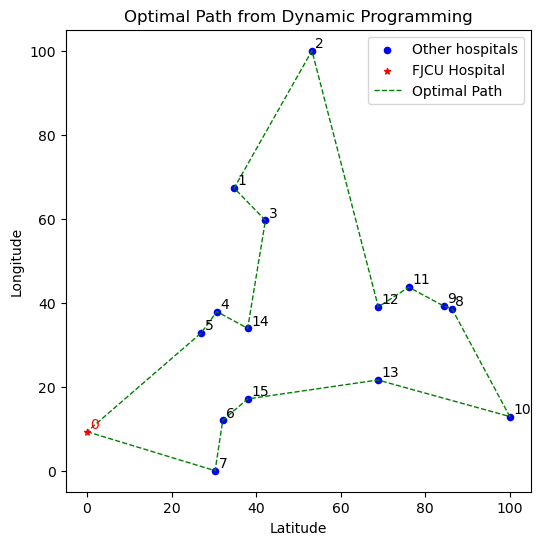

In [34]:
path_coords = coordinates[dp_optimal_path]
path_x = path_coords[:, 0]
path_y = path_coords[:, 1]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Optimal Path from Dynamic Programming")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

ax.scatter(
    coordinates[1:, 0], coordinates[1:, 1], s=20, color="blue", label="Other hospitals"
)
ax.scatter(
    coordinates[0, 0],
    coordinates[0, 1],
    color="red",
    marker="*",
    s=20,
    zorder=5,
    label="FJCU Hospital",
)
ax.plot(
    path_x, path_y, color="green", linewidth=1, linestyle="--", label="Optimal Path"
)

for index, row in df_hospital.iterrows():
    text_color = "red" if index == 0 else "black"
    ax.text(
        row["x"] + 0.8,
        row["y"] + 0.8,
        str(index),
        ha="left",
        color=text_color,
    )
ax.legend()
plt.show()

### Citation

[7] Bellman, R. (1962). Dynamic programming treatment of the travelling salesman problem. Journal of the Association for Computing Machinery (JACM), 9(1), 61–63. https://doi.org/10.1145/321105.32111

[8] Held, M., & Karp, R. M. (1962). A dynamic programming approach to sequencing problems. Journal for the Society for Industrial and Applied Mathematics (JSIAM), 10(1), 196–210. https://doi.org/10.1137/0110015

## Section 3. Nearest Neighbor Heuristic

Nearest Neighbor 的來源並不像 Held-Karp Algorithm 是由兩個原始來源提出 (Bellman, 1962; Held & Karp, 1962)，但是分散很多。多數人認為 Nearest Neighbor 本身是一種 Greedy Algorithm 的直覺上的應用

### Step A. Review on Nearest Neighbor

在 1930 年代之前，任何要規劃路線的人，例如 19 世紀的推銷員或是送貨員，對於這種路線問題，想到的都是「先去最近的下一站」。這也很符合人類平常的生活習慣，所以可以說是一種基於直覺產生的想法。在 1930 年代由 Karl Menger 進行公式化之後（從多個文獻看到，沒找到原始論文），學界普遍認為 Nearest Neighbor Heuristic 已經是顯而易見的方法，但不能保證找到最佳解

Nearest Neighbor 演算法並這有標準定義，但 Rosenkrantz et al., (1977) 針對 TSP 中的 _2. Nearest Neighbor_ 有給出演算法建立流程 [9]。過程如下

1. 從任意節點開始
2. 找到尚未在路徑中的節點，該節點必須是距離最近添加的節點最近的。將連接這兩個節點的邊加入路徑中
3. 當所有節點都被加入路徑後，添加一條邊連接起始節點和最後一個添加的節點，形成一個迴路

作者同時假設當 step 2 中出現平手（距離最近的節點不只一個）時，可以任意打破平手；同時注意到 Nearest Neighbor 演算法的時間複雜度，與節點數 $n$ 的平方成正比，即 $O(n^2)$

這些內容會在 _Step B. Implementation_ 中進行。

Rosenkrantz et al., (1977) 同時將啟發式演算法引入近似比例的概念，並證明 Nearest Neighbor 演算法在 $N$ 個城市的近似比例為

$$
\frac{W_{NN}}{W_{Opt}} \le \frac{1}{2}(\lceil \log_2 N \rceil + 1)
$$

代表 NN 演算法的近似比例為 $O(\log N)$，在最壞情況下，NN 找到的路徑長度可能是最佳路徑的 $\log N$ 倍。因此對於 $N=16$ 有 $O(\log 16) = O(4)$，代表 Nearest Neighbor 找到的解在最壞情況下，可能是最佳解的數倍之多，相較於 DP 法有保證 1 倍多的近似解

而 Cormen et al. (2022) 在書中第 15 章的第 427 頁有討論到 Greedy Algorithm 的性質 [5]，說明 

> _The first key ingredient is the greedy-choice property: you can assemble a globally optimal solution by making locally optimal (greedy) choices. In other words, when you are considering which choice to make, you make the choice that looks best in the current problem, without considering results from subproblems._

核心概念就是：在每一步都做出當下看起來最好的選擇（即局部最佳解），並期望這一系列局部最佳解能導向「全域最佳解」

### Step B. Implementation

根據 Rosenkrantz et al., (1977) 中的內容，會需要以下內容

1. 一個清單 `nn_path = [0]` 來儲存路徑
2. 一個追蹤哪些節點已經走訪過的方式，可以寫為 `visited = np.zeros(N, dtype=bool)` 且第一個肯定已經走訪過，因此 `visited[0] = True`。其中 `N` 在前面已經有賦值過了

在 Python 中，最直觀的方式就是用 set 與 boolean 陣列處理。架構如下：

```py
for _ in range(N - 1):
    d_min_to_next = float('inf')
    node_next = -1
    # TODO: A for-loop for Step 2 from Rosenkrantz et al., (1977)
    # TODO: Add the next node into the path

# TODO: Step 3 from Rosenkrantz et al., (1977)
```

那因為把節點都加入路徑中之後，就要更新目前的節點指標。思考一下，每一個節點都會有目前的 value 跟 next 指標指向一個節點，所以在 Step 2. 中可以用 Linked List 去思考，就會清楚很多。因此程式碼可以這樣組合

In [35]:
nn_path = [0]
visited = np.zeros(N, dtype=bool)
visited[0] = True
node_curr = 0
nn_d_total = 0

start_time = time.perf_counter()

for _ in range(N - 1):
    d_min_to_next = float("inf")
    node_next = -1

    # Step 2.
    for j in range(N):
        if not visited[j]:
            dist = distance_matrix[node_curr][j]
            # Update dist if j update
            if dist < d_min_to_next:
                d_min_to_next = dist
                node_next = j

    if node_next == -1: # break if no next node
        break

    # add node_next into path, akin to Linked List
    nn_path.append(node_next)
    visited[node_next] = True
    nn_d_total += d_min_to_next
    node_curr = node_next

# Step 3.
nn_d_total += distance_matrix[node_curr][0]
nn_path.append(0)

end_time = time.perf_counter()

接下來將執行結果印出。可以 Nearest Neighbor Heuristic 演算法注意到整個流程只用了 0.0002 秒，可以說是在一瞬間就完成了

In [36]:
print(f"NNH calculation time: {end_time - start_time:.4f} seconds")
print(f"NNH Distance: {nn_d_total}")
print(f"NNH Path: {nn_path}")

NNH calculation time: 0.0001 seconds
NNH Distance: 405.78800780037
NNH Path: [0, 7, 6, 15, 14, 4, 5, 3, 1, 2, 11, 12, 9, 8, 13, 10, 0]


### Step C. Visualization

陣列還是不太好看，因此直接將陣列視覺化

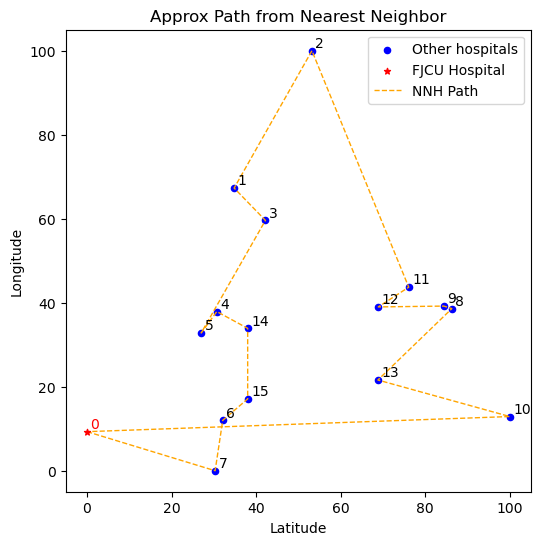

In [37]:
path_coords = coordinates[nn_path]
path_x = path_coords[:, 0]
path_y = path_coords[:, 1]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Approx Path from Nearest Neighbor")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

ax.scatter(
    coordinates[1:, 0], coordinates[1:, 1], s=20, color="blue", label="Other hospitals"
)
ax.scatter(
    coordinates[0, 0],
    coordinates[0, 1],
    color="red",
    marker="*",
    s=20,
    zorder=5,
    label="FJCU Hospital",
)
for index, row in df_hospital.iterrows():
    text_color = "red" if index == 0 else "black"
    ax.text(
        row["x"] + 0.8,
        row["y"] + 0.8,
        str(index),
        fontsize=10,
        ha="left",
        color=text_color,
    )
    
ax.plot(path_x, path_y, color="orange", linewidth=1, linestyle="--", label="NNH Path")
ax.legend()
plt.show()

比較這與 DP 的輸出結果，可以發現近似解的 NNH 與精確解的 DP 路徑存有落差。所以現在有一個問題是：NNH 找到的解，比 DP 找到的最佳解多了百分之多少的距離？

在以上程式碼中，會對應到以下公式，且可以轉換成百分比輸出

$$
\text{Err \%} = \frac{(\text{nn\_d\_total} - \text{dp\_d\_shortest})}{\text{dp\_d\_shortest}}
$$

In [55]:
error_ratio_nnh = (nn_d_total - dp_d_shortest) / dp_d_shortest

print("Optimal Distance from DP", format(dp_d_shortest, ".4f"))
print("Approx Distance from NNH", format(nn_d_total, ".4f"))

print("Error Ratio NNH", format(error_ratio_nnh * 100, ".2f") + "%")

Optimal Distance from DP 351.9501
Approx Distance from NNH 405.7880
Error Ratio NNH 15.30%


### Step D. Trade-off

目前看起來，多花幾秒鐘來換取 15.30% 的精確度還算是很值得的。根據 $N=16$ 對應到 DP 的 $O(16^2 \cdot 2^{16}) \approx 1.67 \times 10^7$ 需要用 0.6573 秒；而對應到 NNH 的 $O(16^2) = 256$ 只要 0.0002 秒

這時來考量運算效率，每 10 億次運算需要 1864.91 秒。如果要配送 50 間醫院，則對於 NNH 來說，只需要 $O(50^2) = 2,500$ 也幾乎是瞬間完成；但若是用 DP 處理，則大約是 $O(50^2 \cdot 2^{50}) \approx 2.8 \times 10^{18}$，這計算量為

$$
\begin{aligned}
T_{\text{total}} &= \left( \frac{2.8 \times 10^{18} \text{ ops}}{10^9 \text{ ops}} \right) \times 1864.91 \text{ sec} \\
&= 2.8 \times 10^{(18-9)} \times 1864.91 \text{ sec} \\
&= 2.8 \times 10^9 \times 1864.91 \text{ sec} \\
&= 5,221,748,000,000 \text{ sec}
\end{aligned}
$$

換算一下

$$
T_{\text{days}} = \frac{5,221,748,000,000 \text{ s}}{86,400 \text{ s/day}} \approx 60,436,898.1 \text{ days}
$$

$$
T_{\text{years}} = \frac{60,436,898.1 \text{ days}}{365.25 \text{ days/year}} \approx 165,469.0 \text{ years}
$$

所以工程上的考量就是

> 是否願意接受 15.30% 的誤差，來換取一個可以在 0.01 秒內給出答案的演算法；還是堅持 0% 的誤差，但永遠等不到答案？

但有沒有可能縮小 15.30% 的誤差？其實還是有可能的。基因演算法（Genetic Algorithm）的目標，就是嘗試在 **極快但誤差大的 NNH** 與 **極慢但完美的 DP** 之間，能夠找到一個平衡點

### Citation

[9] Rosenkrantz, D. J., Stearns, R. E., & Lewis, P. M. (1977). An analysis of several heuristics for the traveling salesman problem. _SIAM Journal on Computing_, 6(3), 563–581 https://doi.org/10.1137/0206041

## Section 4. Genetic Algorithm

### Step A. What is Genetic Algorithm, GA

GA 這一整個領域，通常會歸功在 John Holland 於 1970 年代的一些研究工作上

Holland, J. H. (1975) 在他的教科書中，主要是想要研究生物這種「適應性系統」（Adaptive Systems），也就是說如何在複雜環境中進行演化的。他當時把正個流程分為五個階段，依序為 族群（Population）、適應度（Fitness）、選擇（Selection）、交配（Crossover）、以及突變（Mutation）。以下會在 _Step B_ 到 _Step F_ 中逐一說明，並在 _Step G_ 進行整合 [10]

### Step B. Population

##### Definition 6. Population

族群 $P$ 定義為一個大小為 $N$ 的個體（染色體 $\pi$）的多重集合 $P_t = \{ \pi_1, \pi_2, \dots, \pi_N \}_t$。其中 

- $N = |P_t|$ 
- 搜尋空間 $\Pi_V$ 即為所有排列的集合，而 $\pi \in \Pi_V$

$\blacksquare$

`routes.csv` 檔案就是有 100 條隨機路徑的初始族群，所以這步驟基本上就直接跳過，先讀取出來就好

In [39]:
df_routes = pd.read_csv("routes.csv")
df_routes.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,12,7,6,13,3,14,1,15,2,4,8,10,5,11,9
1,0,1,2,8,7,9,10,14,6,15,11,4,5,12,13,3
2,0,1,11,9,14,12,3,13,6,8,7,10,5,15,2,4
3,0,14,13,7,1,11,3,10,8,15,6,5,2,4,9,12
4,0,2,1,14,4,11,15,13,10,7,8,3,12,5,6,9


這裡以 `df_route[0]` 來說，可以注意到 $\pi_1$ 對應到就是表格中的數字 `0`、而 $\pi_2$ 就是數字 `12`...、$\pi_{15}$ 就是數字 `9`

如果沒有 `routes.csv`，則可以用兩種方式產生。其一是 完全隨機初始化（Random Initialization）、另一種是 啟發式初始化（Heuristic Initialization / Seeding）

#### Step B.1 Random Initialization

這方法就是直接建立 100 次的迴圈，並在每一個迴圈中建立一個新的個體，也就是路徑

每一個路徑的第一個節點都固定為 0，而後進行隨機排列。隨機排列的方式一般會是先建立一個包含所有其他 15 個節點的清單 `node_to_visit`，然後用 `numpy.random.shuffle(nodes_to_visit)` 或 `numpy.random.permutation` 將這個清單完全隨機打亂

接下來就可以將打亂後的 `nodes_to_visit` 附加到 `[0]` 後面形成一條完整的 16 節點路徑。逐一把每一個 row 加入到 `routes.csv` 即可

這樣做的好處在於，初始族群中的每一條路徑可以說是幾乎沒有相關性。所以在要透過 GA 做這種資料要做 crossover 時，不同特徵的資料就會相對充分。但問題在於，隨機路徑的平均距離可能會比較常，所以 GA 會需要比較多的 世代 才能收斂解出來

#### Step B.2 Heuristic Initialization

如同前面已經先做了 NNH，那可以將這條路徑作為一個初始路徑。但因為這只有一筆資料，做 GA 需要相對多的資料才得以進行。這時候就可以將 NNH 路徑隨機執行 2 次 Swap 來產生新路徑。如果將這動作重複執行 20 次，就可以產生 20 條「圍繞在 NNH 解附近」的路徑；而剩下的 79 個空位，就可以再用 Random Initialization 補充。這操作在於要快速增加收斂的速度，可能在前 10 個世代就先收斂到最佳解

但缺點也在這裡，就是如果「種子」太強勢，例如 100 條路徑都是 NNH 的變體，那族群的「基因多樣性」就會變得非常低。屆時會觀察到 GA 可能會迅速收斂到 NNH 的 405.78 這個解，然後卡住，無法「跳出」這個局部最佳解去尋找 351.95 的全局最佳解

### Step C. Fitness

#### Step C.1 Cost Function

回顧在 _Definition 3_ 中有提到，TSP 本身是一個 Hamiltonian Cycle，節點是醫院、邊就是路徑 $\pi$、迴路就是由一系列的邊與路段首尾連接而成。每一個路段都有一個成本，定義為 $w(a, b)$，那一個迴路的總成本（總距離），就是構成該迴路的所有路段長度之和。可以看到 _Definition 4_ 的最佳化問題就是在講如何找到最佳距離

前面提到 GA 演算法就是一個模擬演化的過程，那這想法是從 Darwin, C. (1859) 提到的 **適者生存（Survival of the Fittest）** 演變而來的，而對於「適者生存」要能夠實作本身就需要區分「適者」與「不適者」 [11]

這樣可以區分

1. 適者為 一條配送效率高的短距離路徑
2. 不適者為 一條配送效率低的長距離路徑

所以這時候要解決的最佳化問題為 $\pi^* := \arg\min_{\pi \in \Pi_V} W(\pi)$，無論用哪一種演算法，都必須有一個基礎機制來計算成本函數 $W(\pi)$，即任何給定路徑 $\pi$ 的總距離。如果採用 _Definition 4_ 的最佳化問題定義，可以令 $\pi$ 為 $V$ 上的一個 UHC（Definition 2），且 $V$ 的節點數為 $n$（在作業中的 $n=16$）。所以 $\pi$ 寫成是一個 0-based 指標的排列

$$
\pi = \langle \pi_0, \pi_1, \dots, \pi_{n-1} \rangle
$$

其中 $\pi_0 = 0$。這時候 $W(\pi)$ 可改寫為 0-based 指標

$$
W(\pi) := \underbrace{\left( \sum_{i=0}^{n-2} w(\{\pi_i, \pi_{i+1}\}) \right)}_{W_{\text{open}}(\pi)} + \underbrace{w(\{\pi_{n-1}, \pi_0\})}_{W_{\text{close}}(\pi)}
$$

可以注意到 $W(\pi)$ 中有兩個互斥的部分，分別是 

1. 開放路徑成本 $W_{\text{open}}(\pi)$，代表從 $\pi_0$ 走到 $\pi_{n-1}$ 所經過的 $n-1$ 條邊的總權重
2. 閉合迴路成本 $W_{\text{close}}(\pi)$，代表從最後一個節點 $\pi_{n-1}$ 走回起點 $\pi_0$ 的單條邊權重

那因為 GA 需要重複計算數百次，就是包含對 100 個個體計算適應度，然後為每一個子代也都計算適應度，所以就可以將這個過程定義成一個獨立的函數 `d_total_ga_calc(path_series)`

這裡實作上要注意到，一個 Pandas Series `path_series` 就是 $\pi$，首先會先將傳入的 Pandas Series 轉為 NumPy array，這樣才方便抓取到最後一個元素

```py
def d_total_ga_calc(path_series):
    path = path_series.values
    ...
```

隨後要實作 $W(\pi)$ 本身，這裡就是把 Python set 對應到 series 裡面會分為

1. $\pi_i$ 對應到 `path[i]`
2. $\pi_{i+1}$ 對應到 `path[i+1]`
3. $\pi_{n-1}$ 對應到 `path[-1]`

In [ ]:
def d_total_ga_calc(path_series):
    path = path_series.values

    d_total_ga = 0
    node_num = len(path)  # = 16

    # 1. W_open
    for i in range(node_num - 1):
        node_a = path[i]  # π_i
        node_b = path[i + 1]
        d_total_ga += distance_matrix[node_a, node_b]

    # 2. W_close
    node_last = path[-1]  # π_(n-1)
    node_first = path[0]  # π_0

    # 3. W_open + W_close accumulates to W_π 
    d_total_ga += distance_matrix[node_last, node_first]

    return d_total_ga  # W_π

#### Step C.2 Population Evaluation

在 $W(\pi)$ 的實作 `d_total_ga_calc` 函數被定義之後，下一步就是將這距離用在 初始族群 $P_0$ 上，並帶入「適者」與「不適者」的量化方法，也就是適應度函數 $f(\pi)$

##### Definition 7. Fitness Function

將個體映射到非負實數的函數 $f: \Pi_V \to \mathbf{R}^+$

$\blacksquare$

一個很簡單的想法是，如果距離越大，那適應度就越差；反之則越佳。因此可以定義一個 $f(\pi)$，使得 $W(\pi)$ 的最小值對應於 $f(\pi)$ 的最大值，那最直觀就是

$$
f(\pi) := \frac{1}{W(\pi)}
$$

現在問題在於

> 如何對一個 Pandas 表格計算 $W(\pi)$？

這情況可以用 [`pandas.DataFrame.apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) 處理；隨後可以把 距離 `distance` 和 適應度 `fitness` 儲存在 `df_routes` 的新欄位

In [ ]:
distances = df_routes.apply(d_total_ga_calc, axis=1)

df_routes["distance"] = distances
df_routes["fitness"] = 1 / df_routes["distance"]

可以先對 $P_0$ 中所有 $\pi_i$ 進行 $W(\pi_i)$ 和 $f(\pi_i)$ 測試計算，隨後將最佳與最糟結果印出來看。針對結果得排序，可以用 [`pandas.DataFrame.sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html#pandas-dataframe-sort-values) 處理

In [42]:
print("Initial Population, Best of Gen 0):")
print(df_routes.sort_values(by="fitness", ascending=False).head())
print()
print("Initial Population, Worst of Gen 0):")
print(df_routes.sort_values(by="fitness", ascending=True).head())

Initial Population, Best of Gen 0):
    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15    distance  \
30  0  12   3   2   1  14   6   4   5   9  13   8  10  11  15   7  547.312627   
38  0  15   7   6  14  13  10   5   9   4   1   3   2  12   8  11  602.596832   
35  0   8  10  14   1   2   5   9  11  13  12   3   7  15   4   6  630.242797   
50  0   6  13   7  11  10  12  14   1   3   2   4  15   5   8   9  632.983627   
31  0   7   6   5  15   9  13  14   2   4  10  11   3   1   8  12  638.539130   

     fitness  
30  0.001827  
38  0.001659  
35  0.001587  
50  0.001580  
31  0.001566  

Initial Population, Worst of Gen 0):
    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15    distance  \
6   0  12   3   8   7   1   6  11   2  14   9   4   5  13  15  10  874.587924   
41  0   4  11  15   8   5   3   9   6   2  13  12  14  10   7   1  873.860912   
37  0   2   7   5  11   8   1  15  12   6  10   4  13  14   3   9  873.815489   
43  0   2   7   9  10  15

在這裡已經透過 `df_routes['fitness'] = ...` 計算族群 $P_t$ 中每一個 $\pi_i$ 的適應度 $f(\pi_i)$，現在就可以進行「適者生存」的機制的實作。那要先思考一個問題

> 有了 $P_t$。要如何產生下一代 $P_{t+1}$？

### Step D. Selection

根據「適者生存」的原則，可以發現 $P_{t+1}$ 必須透過 $P_t$ 中「適者」的繁衍來產生，也就是說不能用 **離散型均勻分布** 的方式抽樣出「適者」。因為 **均勻** 代表 **$P_t$ 中的每一個體 $\pi_i$ 被選中的機率 $p_{\text{select}}$ 是完全相等的**，而這樣就會把適者與不適者一視同仁而完全忽略掉 Evaluation 的所有機制

因此想法上，會在 $P_t$（目前族群）中的所有個體 $\pi_i$ 經過 $f(\pi_i)$ 評估後，就會透過抽樣的方式篩選出一個新的中介多重集合 $M_t$，做為被允許進入下一階段繁衍的倖存者。這裡會引入 **選擇壓力** 的概念，用來衡量一個演化系統（族群）篩選機制對於適應度高低差異的放大程度，主要是給予 $f(\pi)$ 更高的個體更大的機率進入下一代族群，驅動演算法朝向最佳解的方向演進。換句話說，「選擇壓力」就是必須要機率性地偏好（probabilistically favor）那些 $f(\pi)$ 值較高的個體，在形式上即為一個選擇機率 $p_{\text{select}}(\pi_i)$。而 $p_{\text{select}}(\pi_i)$ 代表 $P_t$ 中的個體 $\pi_i$ 被選中繁衍的機率，且此機率必須是其適應度 $f(\pi_i)$ 的單調遞增函數

而這個中介集合 $M_t$ 必須是一個多重集合，因為 $f(\pi)$ 較高的「適者」$\pi_i$ 可能會被此程序選中多次，而 $f(\pi)$ 較低的「不適者」$\pi_j$ 可能一次都選不中，從而在 $M_t$ 中出現 0 次。針對這種將 $P_t$ 轉換為 $M_t$ 的隨機過程機制，可以給出以下定義：

##### Definition 8. Stochastic Mapping

隨機映射 $\mathcal{S}: P_t \to M_t$ 為一個選擇機率 $p_{\text{select}}(\pi_i)$ 的演算法

$\blacksquare$

#### Step D.1 Common Algorithms

這裡有數種常見的選擇方法 $\mathcal{S}$：

1.  **Roulette Wheel Selection** [10]

    Holland, J. H. (1975) 假設適應度 $f_i > 0, \quad \forall \: i$。個體 $\pi_i$ 的選擇機率 $p_{\text{select}}(\pi_i)$ 與其適應度 $f_i$ 成正比，並通過族群總適應度 $F = \sum_{j=1}^{N} f_j$ 進行機率正規化以讓機率值滿足 $0 \le p_{\text{select}}(\pi_i) \le 1, \quad \forall \: i$

    $$
    p_{\text{select}}(\pi_i) = \frac{f_i}{\sum_{j=1}^{N} f_j}
    $$

    這裡可以從數學機制中注意到，如果族群中存在一個「超級個體」，其 $f(\pi)$ 值遠高於其他個體的，這時 $p_{\text{select}}$ 將極度偏向超級個體，導致族群多樣性迅速崩潰而掉入局部最佳解。這樣在演化後期，若所有 $f(\pi)$ 值都很接近，選擇壓力會消失導致選擇機制退化成隨機搜尋

2.  **Tournament Selection** [12]

    Brindle, A. (1981) 用競賽的思維去思考，定義大小為 $k \in [1, N]$。則 $p_{\text{select}}(\pi_i)$ 是 $\pi_i$ 在一次競賽中獲勝的機率。其中 **一次競賽** 是從 $P_t$ 中（通常採「重複抽樣」）隨機選出 $k$ 個個體，而適應度 $f(\pi_i)$ 最高者獲勝

    在計算 $p_{\text{select}}(\pi_i)$ 之前，就需要先定義 $\pi_i$ 的排名 $R_i \in \{1, ..., N\}$，而 $R_i=1$ 為適應度最低者，$R_i=N$ 為適應度最高者。則個體 $\pi_i$ 獲勝的機率，等於「所有 $k$ 個抽樣個體的排名均 $\le R_i$」的機率，減去「所有 $k$ 個抽樣個體的排名均 $\le R_i-1$」的機率

    $$
    p_{\text{select}}(\pi_i) = \left(\frac{R_i}{N}\right)^k - \left(\frac{R_i-1}{N}\right)^k
    $$

3.  **Rank-Based Selection** [13]

    Baker, J. E. (1985) 認為 Roulette Wheel Selection 公式中的 $f_i$ 分佈，會影響到整個機率的敏感性，因此主張個體的選擇機率與其適應度 $f_i$ 無關，而是與其在族群中的排名 $R_i$ 成正比。令 $R_i \in \{1, ..., N\}$ 為 $\pi_i$ 的排名，則在線性排序中，可以分配一個虛擬適應度 $f'_i = R_i$，這樣 $p_{\text{select}}(\pi_i)$ 即為 $f'_i$ 在總排名和中的比例

    $$
    p_{\text{select}}(\pi_i) = \frac{R_i}{\sum_{j=1}^{N} j} = \frac{R_i}{\frac{N(N+1)}{2}} = \frac{2 R_i}{N(N+1)}
    $$

4.  **Stochastic Universal Sampling** [14]

    Baker, J. E. (1987) 是在抽樣機制上做 $N$ 次獨立的 Bernoulli Test，以將抽樣變異數降到最低。也就是直接選定一個底層的選擇機率 $p_i$ 來單次產生 $N$ 個樣本（即交配池 $M_t$），而非定義 $p_{\text{select}}(\pi_i)$

    令 $\pi_i$ 在 $M_t$ 中出現的次數為 $C_i(\pi_i)$，則根據 Bernoulli Distribution 得到期望值 $E[C_i] = N \cdot p_i$。這時 $E[C_i]$ 為 $\pi_i$ 的期望被選中次數，滿足

    $$
    \lfloor N \cdot p_i \rfloor \le C_i(\pi_i) \le \lceil N \cdot p_i \rceil
    $$

    這個機制可以確保 $\pi_i$ 的實際抽樣計數與其期望計數的誤差小於 1，會顯著低於 Roulette Wheel Selection

5.  **Truncation Selection** [15]

    Mühlenbein, H., & Schlierkamp-Voosen, D. (1993) 相較於 Stochastic Universal Sampling，則是採用均勻隨機抽樣。定義一個截斷閾值 $\tau \in (0, 1]$，則只有族群中適應度排名前 $k = \lfloor \tau N \rfloor$ 的個體有機會被選中，定義為精英集 $P'_{\text{elite}}$。則在 $P'_{\text{elite}}$ 內部

    $$
    p_{\text{select}}(\pi_i) =
    \begin{cases}
    \frac{1}{k} & \text{if } \pi_i \in P'_{\text{elite}} \\
    0 & \text{if } \pi_i \notin P'_{\text{elite}}
    \end{cases}
    $$

6.  **Boltzmann Selection** [16]

    Goldberg, D. E. (1990) 是借用熱力學中的模擬退火（Simulated Annealing）的概念，以夠過 溫度 $T$ 來控制選擇壓力。即設 $T > 0$ 為溫度參數，則個體 $\pi_i$ 的選擇機率 $p_{\text{select}}(\pi_i)$ 是其 $f_i$ 經過 Boltzmann distribution 轉換後的比例

    $$
    p_{\text{select}}(\pi_i) = \frac{e^{f_i / T}}{\sum_{j=1}^{N} e^{f_j / T}}
    $$

    -  當 $T \to \infty$ 時，$p_{\text{select}}(\pi_i) \to 1/N$ 收斂為 均勻隨機選擇
    -  當 $T \to 0^+$ 時則演變為 Greedy Selection
        -   對於 $f_i$ 最高者 $p_{\text{select}}(\pi_i) \to 1$
        -   對於其他個體 $p_{\text{select}} \to 0$

    參考自 Laarhoven et al. (1987) 對模擬退火機制的解釋，是在較高溫度期間進行週期性的改變，以避免陷入局部最佳解的狀況 [17]

#### Step D.2 How to Trade off

由以上內容可以注意到，$\mathcal{S}$ 運算子的選擇會顯著影響 GA 的收斂行為。而對於 TSP 這樣的 NP-Hard 問題，其搜尋空間本身可能就是崎嶇不平的特徵，換句話說就是存在很多局部最佳解。這樣 $\mathcal{S}$ 就必須要在以下兩個目標之間權衡：

1. 演算法必須施加足夠的選擇壓力，以便利用已知的優良路徑 `(v_a, v_b, v_c)`，使其在族群中快速傳播並收斂
2. 演算法必須保持足夠的族群多樣性探索搜尋空間，以防止演算法被第一個遇到的「局部最佳解」卡住

而 Roulette 和 Truncation 會因為其對 TSP 的距離函數的適應性差而被排除，主因是因為 Roulette 本身會被適應度縮放鎖影響；而 Truncation 可能會在第一代時，就把存在於一個 $f(\pi)$ 排名在中等的個體關鍵基因（全局最佳解所需）直接丟棄，導致過早收斂到局部最佳解

雖然 Boltzmann Selection 雖然本身有效，但會需要額外調整超參數。因為函數裡面需要設計「退火排程」，即 $T$ 如何隨世代 $t$ 遞減，使得分析 GA 自身的參數（如 $p_c, p_m$）就會變得複雜很多

Stochastic Universal Sampling 本身只是解決 Roulette Wheel 或 Rank-Based 抽樣中的變異數問題，但沒有定義「選擇壓力」本身，因此排除

因此 $\mathcal{S}$ 運算子在 TSP 問題下，就必須使用基於排名機制，因為「排名」不受 $f(\pi)$ 絕對值的縮放問題影響，因此可以在演化後期保持相對穩定的選擇壓力。這樣就可以用 Rank-Based 與 Tournament Selection 進行 TSP 的 GA 演算法

**Why not Rank-Based Selection ?**

這裡以時間複雜度為 $O(k)$ 的 Tournament Selection 為實作對象，因為實作 Rank-Based Selection 會需要在每一代

1. 對整個族群 `N=100` 進行排序以取得 $R_i$ 排名，這本身時間複雜度就是 $O(N \log N)$ 了
2. 計算每一個體 $R_i$ 的選擇機率 $p_{\text{select}}$
3. 用 $p_{\text{select}}$ 實作 Roulette Wheel，就需要再用 $O(N)$ 或 $O(\log N)$ 的時間來抽樣一個親代

也因此 Rank-Based 在每一代 $O(N \log N)$ 的排序成本在計算上比 Tournament 的 $O(k)$ 昂貴許多，因此只使用 Tournament Selection 實作

#### Step D.3 Tournament Selection

依照 Tournament Selection 的 $p_{\text{select}}(\pi_i)$ 演算法內容，可以 `(1)` 從 $P_t$ 中均勻隨機取 $k$ 個體不放回，以 `(2)` 組成一個錦標賽子集 $P_{\text{tourn}} \subset P_t$。隨後 `(3)` 在這 $k$ 個個體中，找出適應度最高的獲勝者 $\pi_{\text{winner}}$ `(4)` 放入交配池 $M_t$。其中

$$\pi_{\text{winner}} := \arg\max_{\pi \in P_{\text{tourn}}} f(\pi)$$

這個步驟要持續到 $M_t$ 被填滿為止

在實作上，可以隨機從族群中挑選 `k` 個個體「比賽」，使 fitness 最高的那個獲勝成為家長，隨後重複此動作來挑選第二個家長

決定錦標賽規模 `k` 值的核心機制就是 選擇壓力，`k` 越大則選擇壓力越大。以下實作中會選擇 `k=5` 實作。而這裡關於 `k=5`（以及 `k=3` 或 `k=7` 等）的選取，是 GA 實踐中經驗法則的結果。因為 `k=5` 本身可以讓 $f(\pi)$ 低的個體（例如排名後 30%）幾乎不被選中；同時又能讓 $f(\pi)$ 較高的個體可以被選入 $M_t$ 中傳播。如果一些 $f(\pi)$ 排名中等但是「運氣好」的個體，可以被選入一個由 5 個 $f(\pi)$ 排名在 30%~60% 的個體組成的錦標賽，仍會有某些機會可以勝出。簡單來說，`k=5` 可以在多樣性與收斂性之間取得平衡，以防止演算法過早收斂

注意，在實作上，因為 `df_population` 包含 `distance` 與 `fitness` 兩個跟基因本身無關的欄位，因此要刪除掉

In [ ]:
def tournament_selection(df_population, k=5):
    population_size = len(df_population)

    tournament_indices = np.random.choice(population_size, k, replace=False)  # (1)
    tournament_contestants = df_population.iloc[tournament_indices]  # (2)
    winner_idx = tournament_contestants["fitness"].idxmax()  # (3)

    winner_path = df_population.loc[winner_idx].drop(["distance", "fitness"]).values 
    return list(winner_path.astype(int))  # (4)

這裡可以執行 $\mathcal{S}$ 兩次，以產生後續所需的兩個親代

In [44]:
parent1 = tournament_selection(df_routes, k=5)
parent2 = tournament_selection(df_routes, k=5)

print("Parent 1 (winner of 1st tournament):\n", parent1)
print()
print("Parent 2 (winner of 2nd tournament):\n", parent2)

Parent 1 (winner of 1st tournament):
 [np.int64(0), np.int64(6), np.int64(13), np.int64(7), np.int64(11), np.int64(10), np.int64(12), np.int64(14), np.int64(1), np.int64(3), np.int64(2), np.int64(4), np.int64(15), np.int64(5), np.int64(8), np.int64(9)]

Parent 2 (winner of 2nd tournament):
 [np.int64(0), np.int64(5), np.int64(11), np.int64(7), np.int64(12), np.int64(14), np.int64(2), np.int64(8), np.int64(10), np.int64(4), np.int64(6), np.int64(3), np.int64(15), np.int64(13), np.int64(9), np.int64(1)]


現在 `parent1` 和 `parent2` 變數就是從這個 $M_t$ 中抽樣的兩個成員

### Step E. Crossover

這裡可以先思考

> 如果只是將 $M_t$ 直接複製到下一代 $P_{t+1}$，會發生什麼事情？

因為 `tournament_selection` 得出的 $M_t$ 將包含大量 $P_t$ 中優良個體，性質上很接近，因此族群的多樣性會很快崩潰。換句話說，演算法會很快就會收斂到其一開始找到的局部最佳解而無法跳脫

所以在這階段的 GA 必須有一種機制，能把 $M_t$ 中不同 fitness 的基因片段組合在一起（即 $M_t \times M_t$），建立出未曾見過的 solution。因此需要新的運算子的定義：

##### Definition 9. Crossover Operator

交配運算子 $\mathcal{C}: (M_t \times M_t) \to P'_{t+1}$ 為從 $M_t$ 中抽取兩個親代 $(\pi_a, \pi_b)$ 後，產生一個或多個子代 $\pi'$ 的基因重組演算法

$\blacksquare$

現在問題的難點就在 $M_t \times M_t$ 的實作。參考 _Definition 2_ 定義 TSP 的解 $\pi$ 必須是一個 UHC 即一個排列，所以 TSP 的 $\mathcal{C}$ 運算子必須是一個保持排列合法性的演算法。如果 $\mathcal{C}$ 是一個二進制編碼（如 `[1, 0, 1, 0, 1]`）的「單點交配」，那產生的子代就會變成「重複包含」而完全遺漏其他節點，導致子代無法構成一個完整的 Hamiltonian Circuit

這裡用具體案例說明會比較容易。注意因為 `parent1` 與 `parent2` 具有隨機性，每次執行都不一樣，因此這部分會定義以下兩個 parent 進行解說

- Parent 1 (`genes_p1`)：`[0, 1, 11, 9, 7, 5, 4, 15, 13, 6, 2, 14, 8, 12, 10, 3]`
- Parent 2 (`genes_p2`)：`[0, 8, 10, 14, 1, 2, 5, 9, 11, 13, 12, 3, 7, 15, 4, 6]`

步驟如下：

1. 因為作業要求起點（節點 0）固定，因此 $\mathcal{C}$ 運算子只會在節點 1 至 15 上操作

    - Parent 1 (`genes_p1`)：`[1, 11, 9, 7, 5, 4, 15, 13, 6, 2, 14, 8, 12, 10, 3]`
    - Parent 2 (`genes_p2`)：`[8, 10, 14, 1, 2, 5, 9, 11, 13, 12, 3, 7, 15, 4, 6]`

2. 演算法會隨機選取兩個切割點 `cut_a` 與 `cut_b`，假定 `cut_a = 3` 與 `cut_b = 8`

3. 演算法會將 Parent 1 在 `[cut_a:cut_b]`（即 `[3:7]`）的基因片段，原封不動複製到子代的相同位置

    - Parent 1 狀態：`[1, 11, 9, (7, 5, 4, 15, 13), 6, 2, 14, 8, 12, 10, 3]`
    - Child 初始狀態：        `[_, _, _, 7, 5, 4, 15, 13, _, _, _, _, _, _, _]`

    因為這個片段會一直用來做複製，因此可以定義 建立一個 `segment_set = {7, 5, 4, 15, 13}` 方便操作

4. 演算法會繼承 Parent 2 的 **相對順序** 來填補 Child 中的 `_`

    1. 首先會建立一個 Parent 2 的填補順序列表 `p2_fill_order`，會從 `cut_b = 8` 開始繞一圈回到開頭

        - `genes_p2[8:] = [13, 12, 3, 7, 15, 4, 6]`
        - `genes_p2[:8] = [8, 10, 14, 1, 2, 5, 9, 11]`

        組合成 `p2_fill_order = [13, 12, 3, 7, 15, 4, 6, 8, 10, 14, 1, 2, 5, 9, 11]`
    
    2. 接著，從 Child 的 `cut_b = 8` 索引位置開始，依序填入 `p2_fill_order` 中的基因，但前提是該基因不在 `segment_set` 中，因此流程會是：

        | scan `p2_fill_order` | in `segment_set`? | Child idx | Child Status |
        | :--- | :--- | :--- | :--- |
        | 13 | 是 | (skip) | `[_, _, _, 7, 5, 4, 15, 13, _, _, _, _, _, _, _]` |
        | 12 | 否 | `Child[8] = 12` | `[_, _, _, 7, 5, 4, 15, 13, 12, _, _, _, _, _, _]` |
        | 3 | 否 | `Child[9] = 3` | `[_, _, _, 7, 5, 4, 15, 13, 12, 3, _, _, _, _, _]` |
        | 7 | 是 | (skip) | ... |
        | 15 | 是 | (skip) | ... |
        | 4 | 是 | (skip) | ... |
        | 6 | 否 | `Child[10] = 6` | `[_, _, _, 7, 5, 4, 15, 13, 12, 3, 6, _, _, _, _]` |
        | 8 | 否 | `Child[11] = 8` | ... |
        | 10 | 否 | `Child[12] = 10` | ... |
        | 14 | 否 | `Child[13] = 14` | ... |
        | 1 | 否 | `Child[14] = 1` | `[_, _, _, 7, 5, 4, 15, 13, 12, 3, 6, 8, 10, 14, 1]` |
        | 2 | 否 | `Child[15 % 15 = 0] = 2` | `[2, _, _, 7, 5, 4, 15, 13, 12, 3, 6, 8, 10, 14, 1]` |
        | 5 | 是 | (skip) | ... |
        | 9 | 否 | `Child[16 % 15 = 1] = 9` | `[2, 9, _, 7, 5, 4, 15, 13, 12, 3, 6, 8, 10, 14, 1]` |
        | 11 | 否 | `Child[17 % 15 = 2] = 11` | `[2, 9, 11, 7, 5, 4, 15, 13, 12, 3, 6, 8, 10, 14, 1]` |

5. 在所有 `_` 都被填滿之後，就產生了子代的 15 個基因。最後只要固定的 0 加回第零位，就可以產生正確的子代 $\pi'$ 為：

    `final_child = [0, 2, 9, 11, 7, 5, 4, 15, 13, 12, 3, 6, 8, 10, 14, 1]`

    這個子代 $\pi'$ 是一個繼承 Parent 1 的「絕對位置」片段和 Parent 2 的「相對順序」的合法 UHC

In [ ]:
def ordered_crossover(parent1, parent2):
    # 1. fix π_0 = 0
    genes_p1 = parent1[1:]
    genes_p2 = parent2[1:]
    gene_len = len(genes_p1)  # n-1 = 15

    # 2. Inherits π_a segment
    cut_points = sorted(np.random.choice(range(gene_len), 2, replace=False))
    cut_a, cut_b = cut_points[0], cut_points[1]

    genes_child = [None] * gene_len

    # copy segment_a to π'
    genes_child[cut_a:cut_b] = genes_p1[cut_a:cut_b]
    segment_set = set(genes_p1[cut_a:cut_b])

    # 3. Inherits relative order of π_b

    p2_fill_order = genes_p2[cut_b:] + genes_p2[:cut_b]
    child_fill_idx = cut_b

    # 4. scan π_b and fill if not in segment_a
    for gene in p2_fill_order:
        if gene not in segment_set:
            genes_child[child_fill_idx % gene_len] = gene
            child_fill_idx += 1

    # 5.
    final_child = [0] + genes_child
    return final_child

測試將 Parent 1 與 Parent 2 進行交配產生子代：

In [46]:
p1 = [int(x) for x in parent1]
p2 = [int(x) for x in parent2]
child1 = ordered_crossover(p1, p2)
child2 = ordered_crossover(p2, p1)

print(f"Parent 1: {p1}")
print(f"Parent 2: {p2}")
print(f"Child 1 (P1 segment, P2 order): {child1}")
print(f"Child 2 (P2 segment, P1 order): {child2}")

Parent 1: [0, 6, 13, 7, 11, 10, 12, 14, 1, 3, 2, 4, 15, 5, 8, 9]
Parent 2: [0, 5, 11, 7, 12, 14, 2, 8, 10, 4, 6, 3, 15, 13, 9, 1]
Child 1 (P1 segment, P2 order): [0, 4, 6, 7, 11, 10, 12, 14, 1, 3, 2, 15, 13, 9, 5, 8]
Child 2 (P2 segment, P1 order): [0, 13, 7, 11, 12, 14, 1, 2, 10, 4, 6, 3, 15, 5, 8, 9]


### Step F. Mutation

現在結果是已通過 $\mathcal{S}$ 從族群 $P_t$ 中生成了中介親代多重集合 $M_t$，隨後透過重複執行 $\mathcal{C}$ 從 $M_t$ 中抽選親代配對，將其基因片段組合以產生一個或多個子代 $\pi'$，並持續執行直到組和出下一子代集合 $P'_{t+1}$

但問題在於，現在 $\mathcal{S}$ 和 $\mathcal{C}$ 擅長使用已知的良好基因，但無法創造出初始族群 $P_0$ 中從未存在過的新基因。如果在 $P_0$ 中由於隨機的偶然性，所有 100 條路徑都包含 `(v_a, v_b)` 這一小段（即節點 $a$ 都是接續 $b$），那 $\mathcal{S}$ 運算子只會選擇包含 `(a, b)` 的個體，而 $\mathcal{C}$ 運算子在組合時也只會傳播 `(a, b)`。這樣演算法就會永遠無法找到 `(a, c)` 或 `(a, d)` 等可能性而過早收斂到一個局部最佳解，只因為「全局最佳解」所需的 $\pi^*$ 不在 $\mathcal{S}$ 和 $\mathcal{C}$ 能夠探索到的範圍內

這樣 GA 必須有一個機制來對抗這種基因多樣性的喪失。生物學中為了維持基因的多樣性而有「突變」的機制，在 GA 中同樣適用：

##### Definition 10. Mutation Operator

隨機映射 $\mathcal{M}: P'_{t+1} \to P_{t+1}$ 定義為接收 $\mathcal{C}$ 產生的子代集合 $P'_{t+1}$ 後，產生最終的下一代族群 $P_{t+1}$ 的過程

其中，令 $\pi''$ 是 $P_{t+1}$ 的最後成員，則對於 $\forall \pi' \in P'_{t+1}$ 進入 $P_{t+1}$ 的形式化過程為

$$
\pi'' = \begin{cases} \mathcal{M}(\pi') & \text{with probability } p_m \\ \pi' & \text{with probability } 1 - p_m \end{cases}
$$

$\mathcal{M}(\pi')$ 是 $\mathcal{M}$ 運算子本身的演算法

$\blacksquare$

可以注意到 $p_m$ 這個超參數，如果 $p_m = 0$，則 GA 就會沒有辦法找到新基因；如果 $p_m$ 過高，則 $\mathcal{S}$ 和 $\mathcal{C}$ 所組合出的「好基因」就會直接被隨機突變摧毀，使 GA 退化為「隨機搜尋」。所以 $p_m$ 必須為一個很低的機率

因為 $\mathcal{M}$ 跟 $\mathcal{C}$ 一樣都是操作 $\pi$ 的表示法，根據 _Definition 2_ 知道 $\pi$ 是一個 UHC 即排列，所以必須採用 **交換突變** 處理。依序是

1. 檢查 $p_m$ 機率
2. 隨機選取兩個不同的索引 $i$ 和 $j$，並依照作業中有關 $\pi_0$ 固定的限制操作，即 $i, j \neq 0$
3. 交換 $\pi'$ 在這兩個索引上的值，即

    - $\pi' = \langle \dots, \pi'_i, \dots, \pi'_j, \dots \rangle$
    - $\mathcal{M}(\pi') = \langle \dots, \pi'_j, \dots, \pi'_i, \dots \rangle$

可以這樣實作：

In [ ]:
import numpy as np


def mutate(child_path, mutation_rate=0.01):
    
    path_mutated = list(child_path)

    # 1.
    if np.random.rand() < mutation_rate:

        # 2. 
        swap_indices = np.random.choice(range(1, len(path_mutated)), 2, replace=False)
        idx1, idx2 = swap_indices[0], swap_indices[1]

        # 3.
        node1 = path_mutated[idx1]
        node2 = path_mutated[idx2]
        path_mutated[idx1] = node2
        path_mutated[idx2] = node1

    # return original path if np.random.rand() >= mutation_rate
    return path_mutated

進行測試：

In [ ]:
print(f"Original Child: {child1}")

child_mutated_high = mutate(child1, mutation_rate=1)
print(f"High Rate Mutated Child:  {child_mutated_high}")

child_mutated_low = mutate(child1, mutation_rate=0.00001)
print(f"Low Rate Mutated Child: {child_mutated_low}")

Original Child: [0, 4, 6, 7, 11, 10, 12, 14, 1, 3, 2, 15, 13, 9, 5, 8]
High Rate Mutated Child:  [0, 4, 6, 7, 11, 10, 13, 14, 1, 3, 2, 15, 12, 9, 5, 8]
Low Rate Mutated Child: [0, 4, 6, 7, 11, 10, 12, 14, 1, 3, 2, 15, 13, 9, 5, 8]


現在有另一個問題出現：為什麼 `tournament_selection` 加上 `ordered_crossover` 就能有效找到好的 TSP 路徑？

Holland (1975) 所提出的基模定理（Schema Theorem）就可以用來解釋 GA 演算法如何透過處理 $N$ 個個體，來同時評估 $N^3$ 甚至更多的基因片段。那現在要先停止分析 完整的路徑 $\pi$，而是轉而分析 $\pi$ 內部的 **基因片段**，即基模（Schema, $H$）

##### Theorem 4. Schema Theorem

對於一個使用「適應度比例選擇法」的基因演算法，其中單點交配發生機率為 $p_c$、位元翻轉突變發生機率為 $p_m$。則一個基模 $H$ 在 $t+1$ 世代的期望實例數量 $E[m(H, t+1)]$ 滿足以下不等式：

$$
E[m(H, t+1)] \ge m(H, t) \cdot \underbrace{\frac{f(H)}{\bar{f}}}_{\text{Selection } (\mathcal{S})} \cdot \underbrace{\left[ 1 - p_c \cdot \frac{\delta(H)}{L-1} \right]}_{\text{Crossover } (\mathcal{C})} \cdot \underbrace{\left[ (1 - p_m)^{o(H)} \right]}_{\text{Mutation } (\mathcal{M})}
$$

$\blacksquare$

**（證明略）**

`tournament_selection` 加上 `ordered_crossover` 就能有效找到好的 TSP 路徑的原因，就在於 $\mathcal{S}$、$\mathcal{C}$、$\mathcal{M}$ 三個運算子都可以被量化

1. **Selection Term $\mathcal{S}$**

    $m(H, t)$ 是 $H$ 在 $t$ 世代的數量、$f(H)$ 是所有*符合* $H$ 的個體 $\pi$ 的**平均適應度**、而 $\bar{f}$ 是 $P_t$ **整個族群**的平均適應度

    `tournament_selection` 的目標就是實作 $\frac{f(H)}{\bar{f}}$。如果如果一個基模 $H$ 是「好的」（就是短路徑），則 $f(H) > \bar{f}$ 使得 $E[m(H, t+1)]$ 可呈指數增長，以確保 $f(\pi)$ 高的個體有更高的機率被複製到交配池 $M_t$

2. **Crossover Term $\mathcal{C}$**

    $p_c$ 是交配率、$L$ 是染色體長度（$L=16$）、$\delta(H)$ 是基模 $H$ 的**定義長度**。這個定義長度即 $H$ 中第一個固定基因和最後一個固定基因之間的距離，例如 `H_1 = [0, *, *, *, *, 5, *, 12, ...]` 的 $\delta(H) = 7 - 5 = 2$

    $\left[ 1 - p_c \cdot \frac{\delta(H)}{L-1} \right]$ 代表 $H$ 在 $\mathcal{C}$ 運算子中**不被破壞**的存活機率，也就是說 $\delta(H)$ 較小的短基模更容易在交配中存活。因此 `ordered_crossover` 本身透過 `cut_a`, `cut_b` 複製 `parent1` 的一個 _連續片段_ 的設計，就是為了最大程度保護這些已適應的短基因片段不被交配過程切斷

3. **Mutation Term $\mathcal{M}$**

    $p_m$ 是突變率、$o(H)$ 是基模 $H$ 的階數。所謂階數就是 **有多少個固定的基因**，例如 `H_1` 的 $o(H)=2$

    因為 `mutate` 是透過破壞基模來進行探索，所以 `MUTATION_RATE` 必須很低才行


### Step G. Integration of GA Implementation

#### Step G.1 Hyperparameter Configuration

在啟動 GA 主迴圈之前，必須先定義演算法的超參數，以便直接控制 _Step D_ 和 _Step F_ 中的「探索」與「利用」權衡

這裡比較特別的是新增一個 `ELITISM_SIZE` 機制，是因為要找出最佳解，所以要確保 $P_t$ 中 $f(\pi)$ 最高的 $k$ 個個體可以不經過 $\mathcal{C}$ 或 $\mathcal{M}$ 的運算，直接複製到 $P_{t+1}$ 以確保 $f(\pi)$ 的最佳解永遠不會在演化中遺失

In [ ]:
NUM_GENERATIONS = 100
POPULATION_SIZE = 100
ELITISM_SIZE = 2
MUTATION_RATE = 0.01  # p_m 
TOURNAMENT_K = 5      # k

SNAPSHOT_GENERATIONS = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, NUM_GENERATIONS - 1]

snapshot_data = {}  # storing path and distance
ga_progress = []  # for sketching convergence trend

df_population_current = df_routes.copy()

#### Step G.2 GA Main Evolution Loop

這裡會透過迴圈執行 `NUM_GENERATIONS` 次 $P_t \to P_{t+1}$ 的狀態轉移，流程是

0. 在演化 _之前_ 就先儲存當前世代的最佳解做為 Snapshot，以便後續可以用來做 `matplotlib` 輸出

1.  **建立 $P_{t+1}$**：
    
    0. 將 $P_t$ 中最好的 `ELITISM_SIZE` 個體直接複製到 `paths_population_new`，重複執行 $N/2$ 次繁衍
    1. 呼叫 $\mathcal{S}$ 的 `tournament_selection` 兩次以取得 $p_1$ 與 $p_2$
    2. 呼叫 $\mathcal{C}$ 的 `ordered_crossover` 產生 $c_1$ 與 $c_2$
    3. 呼叫 $\mathcal{M}$ 的 `mutate` 產生 $m_1$ 與 $m_2$
    4. 將 $m_1$ 與 $m_2$ 加入 `paths_population_new`

2.  **評估 $P_{t+1}$**

    接下來會呼叫 $W(\pi)$ 的 `d_total_ga_calc` 和 $f(\pi)$ 即 `1 / distance` 來評估 `paths_population_new`

3.  **更新 $P_t$** 即 `df_population_current = df_pop_new` 以完成一次世代更迭

In [ ]:
start_time = time.perf_counter()

# GA Main Loop
for gen in range(NUM_GENERATIONS):
    
    # 0.
    if gen in SNAPSHOT_GENERATIONS:
        best_solution = df_population_current.sort_values(
            by="distance", ascending=True
        ).iloc[0]
        best_path = list(best_solution.drop(["distance", "fitness"]).values.astype(int))
        best_dist = best_solution["distance"]
        snapshot_data[gen] = (best_path, best_dist)
        print(f"--- Snapshot captured for Generation {gen} (Dist: {best_dist:.2f}) ---")

    # 1. P_{t+1}
    paths_population_new = []

    # 1.0
    df_paths_best = df_population_current.sort_values(
        by="fitness", ascending=False
    ).head(ELITISM_SIZE)
    for i in range(ELITISM_SIZE):
        elite_path = list(
            df_paths_best.iloc[i].drop(["distance", "fitness"]).values.astype(int)
        )
        paths_population_new.append(elite_path)

    # S -> C -> M
    num_to_breed = (POPULATION_SIZE - ELITISM_SIZE) // 2
    for _ in range(num_to_breed):
        # 1.1
        p1 = tournament_selection(df_population_current, k=TOURNAMENT_K)
        p2 = tournament_selection(df_population_current, k=TOURNAMENT_K)
        # 1.2
        c1 = ordered_crossover(p1, p2)
        c2 = ordered_crossover(p2, p1)
        # 1.3
        m1 = mutate(c1, mutation_rate=MUTATION_RATE)
        m2 = mutate(c2, mutation_rate=MUTATION_RATE)
        # 1.4
        paths_population_new.append(m1)
        paths_population_new.append(m2)

    # 2.
    df_pop_new = pd.DataFrame(paths_population_new)
    new_distances = df_pop_new.apply(d_total_ga_calc, axis=1)
    df_pop_new["distance"] = new_distances
    df_pop_new["fitness"] = 1 / new_distances

    # 3.
    df_population_current = df_pop_new
    best_dist_this_gen = df_population_current["distance"].min()
    ga_progress.append(best_dist_this_gen)

end_time = time.perf_counter()
print(f"GA evolution time: {end_time - start_time:.4f} seconds")

--- Snapshot captured for Generation 0 (Dist: 547.31) ---


--- Snapshot captured for Generation 5 (Dist: 466.71) ---
--- Snapshot captured for Generation 10 (Dist: 416.47) ---
--- Snapshot captured for Generation 20 (Dist: 407.55) ---
--- Snapshot captured for Generation 30 (Dist: 385.53) ---
--- Snapshot captured for Generation 40 (Dist: 373.48) ---
--- Snapshot captured for Generation 50 (Dist: 373.48) ---
--- Snapshot captured for Generation 60 (Dist: 373.48) ---
--- Snapshot captured for Generation 70 (Dist: 373.48) ---
--- Snapshot captured for Generation 80 (Dist: 360.98) ---
--- Snapshot captured for Generation 90 (Dist: 360.98) ---
--- Snapshot captured for Generation 99 (Dist: 360.98) ---
GA evolution time: 1.3438 seconds


可以跟 NNH 一樣，比較看看 GA 與 DP 的誤差率

In [54]:
error_ratio_ga = (best_dist_this_gen - dp_d_shortest) / dp_d_shortest

print("Optimal Distance from DP", format(dp_d_shortest, ".4f"))
print("Approx Distance from GA", format(best_dist_this_gen, ".4f"))

print("Error Ratio", format(error_ratio_ga * 100, ".2f") + "%")

Optimal Distance from DP 351.9501
Approx Distance from GA 360.9822
Error Ratio 2.57%


可以發現 GA 本身的誤差只跟精確解的 DP 相差 2.57%，雖然執行時間多了 2.57 秒（相較於 NNH 僅 0.0002 秒）來看，在某些情況下，這個執行 100 世代運算的時間開銷，在某些情況下還是可以接受的

#### Step G.3 Convergence Analysis

在主迴圈執行完畢後，ga_progress 列表儲存了 $t=0$ 到 $t=19$ 每一代的最佳成本 $W(\pi)$。這時可以將 _Theorem 4_ 進行視覺化，這樣就可以看出 GA 是如何用 $\mathcal{S}$ 和 $\mathcal{C}$ 運算子在短時間內使 $W(\pi)$ 快速收斂

這裡可以引入 `dp_d_shortest` 做為全局最佳解的對照

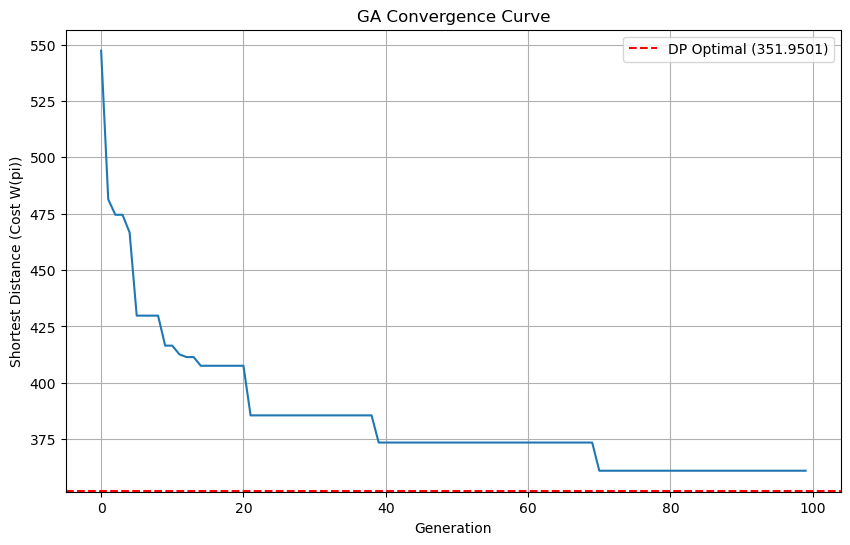

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(ga_progress)
plt.title("GA Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Shortest Distance (Cost W(pi))")
plt.grid(True)
plt.axhline(
    y=dp_d_shortest,
    color="r",
    linestyle="--",
    label=f"DP Optimal ({dp_d_shortest:.4f})",
)
plt.legend()
plt.show()

#### Step G.4 Evolution Snapshots

另外可以將 `snapshot_data` 這個 dict 的 9 個 snapshots 印出來，觀察看看基因演算法如何收斂到「比較好的」局部最佳解，

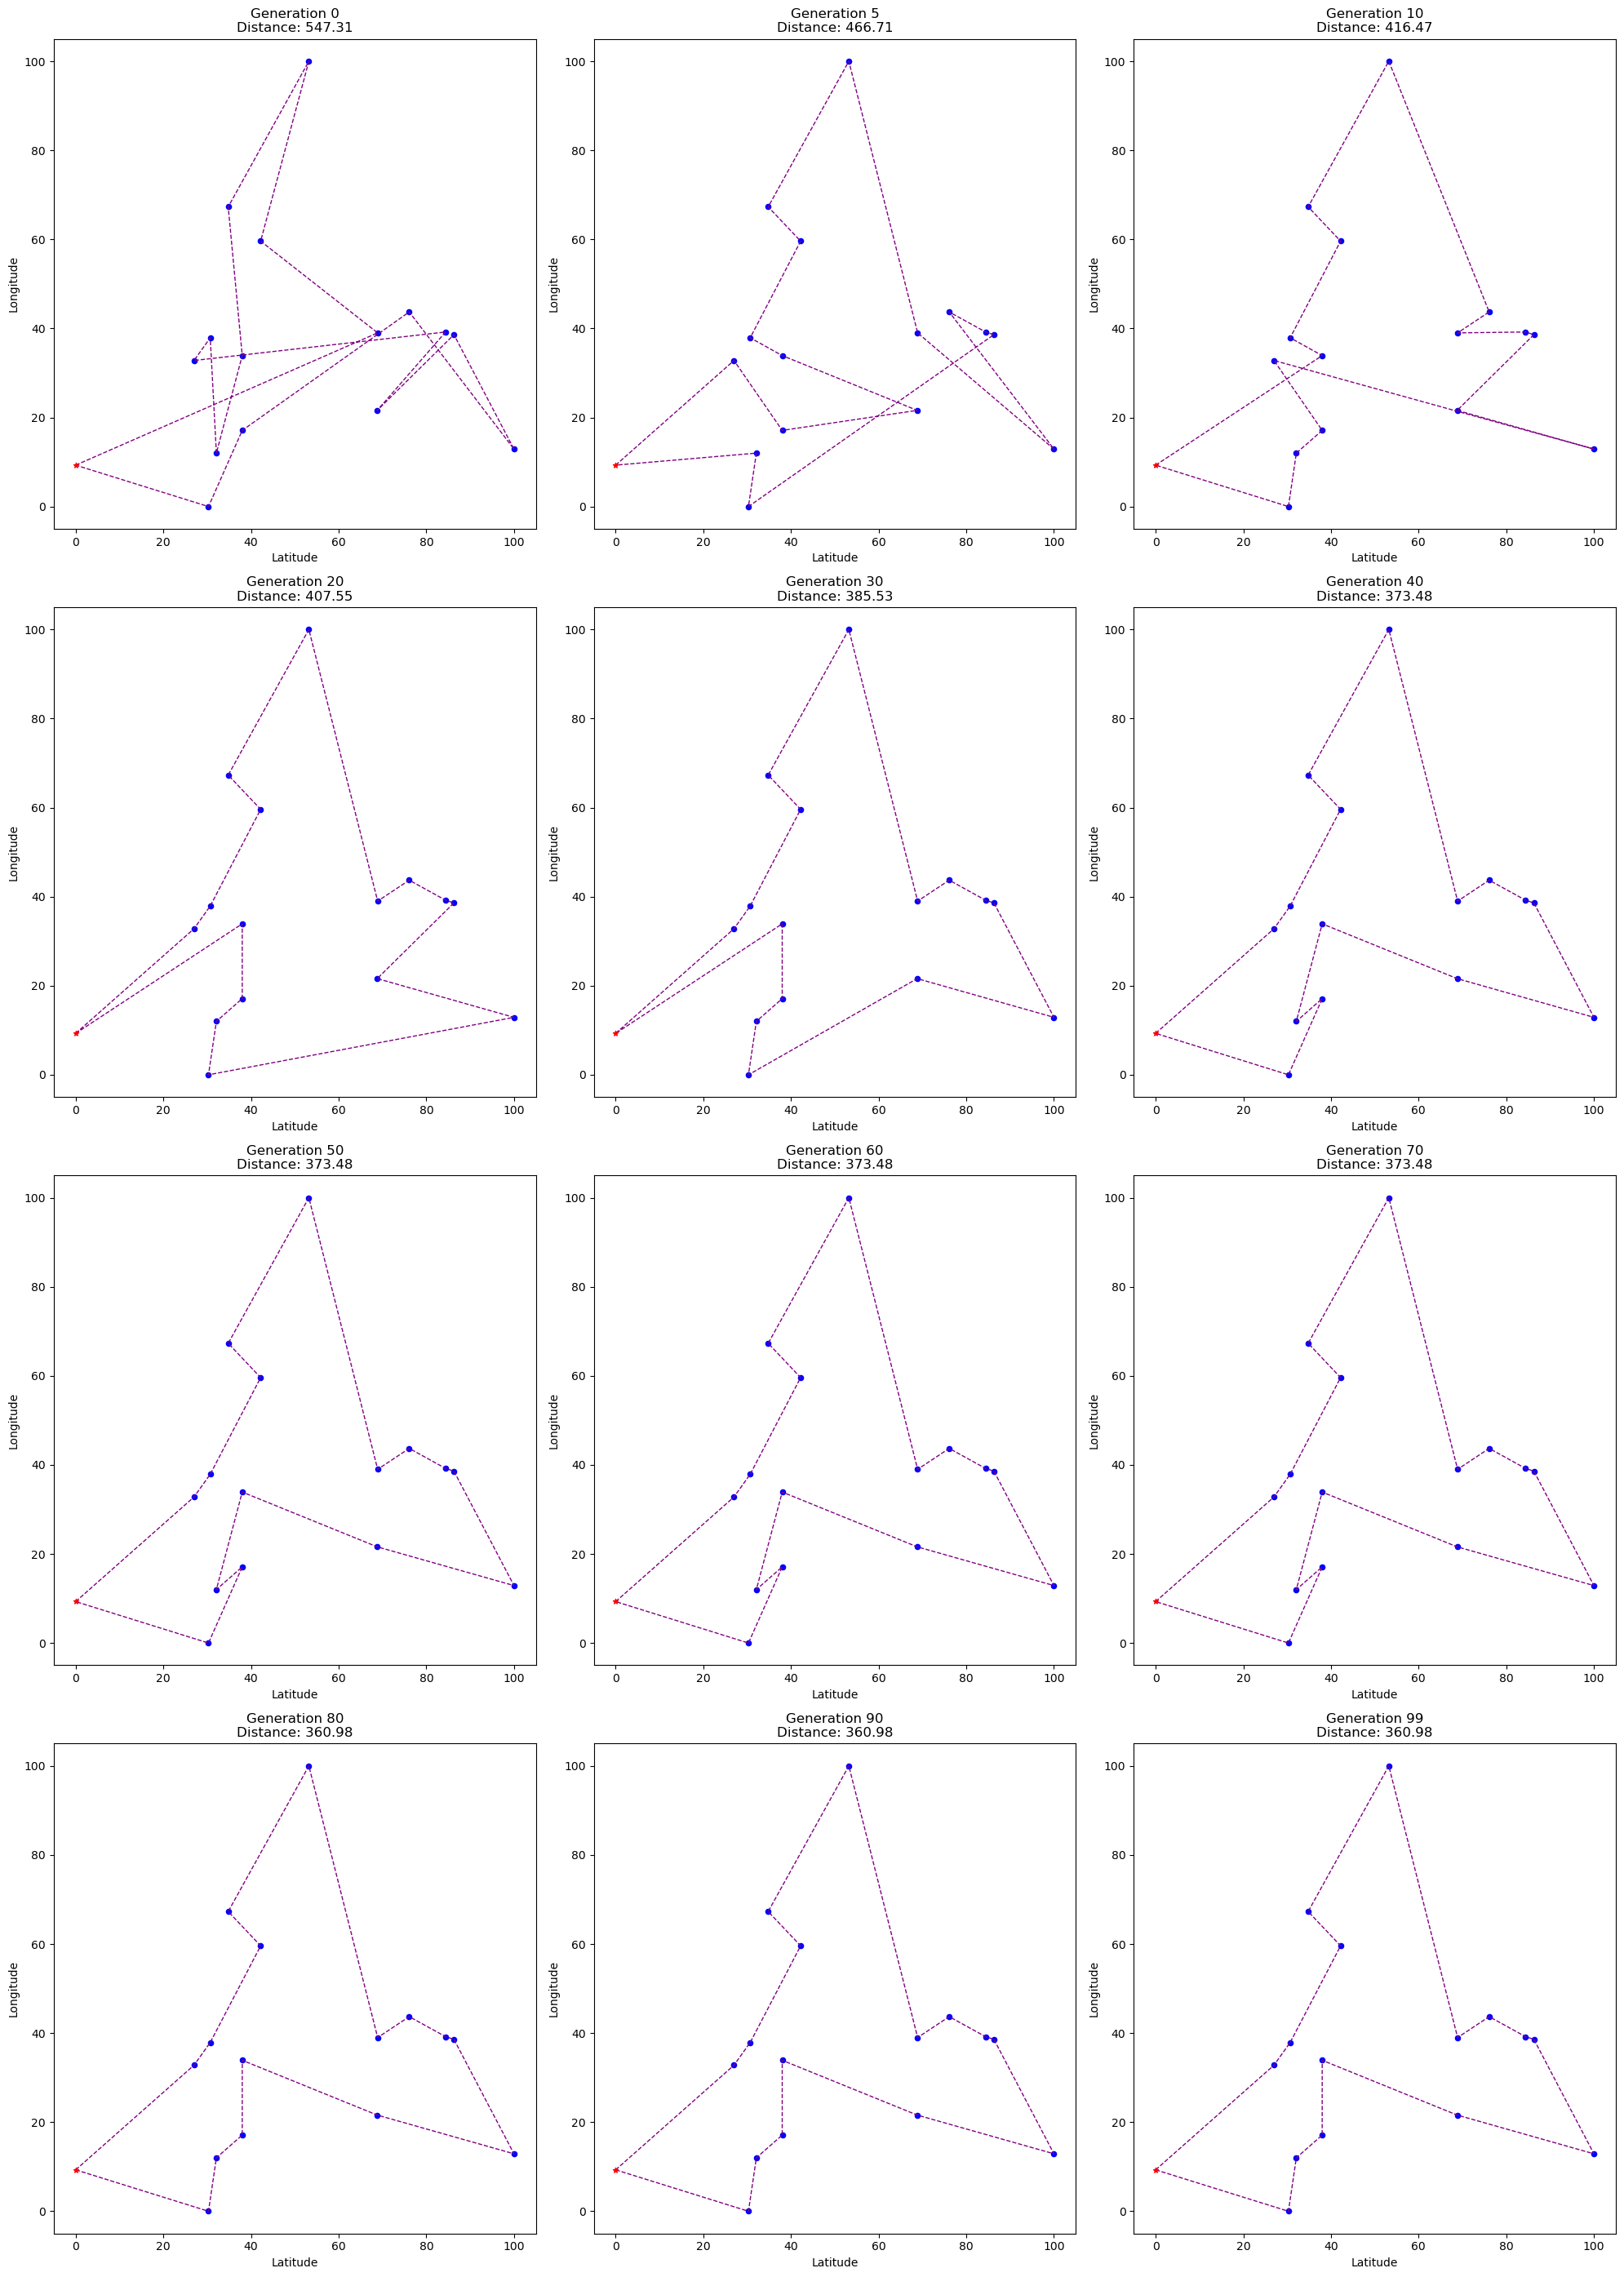

In [52]:
fig, axes = plt.subplots(4, 3, figsize=(20, 28))
axes = axes.flat

sorted_gens = sorted(snapshot_data.keys())

for i, gen in enumerate(sorted_gens):
    path, dist = snapshot_data[gen]
    ax = axes[i]

    path_with_return = path + [0]
    path_coords = coordinates[path_with_return]
    path_x = path_coords[:, 0]
    path_y = path_coords[:, 1]
    ax.plot(path_x, path_y, color="purple", linewidth=1, linestyle="--")

    ax.scatter(coordinates[1:, 0], coordinates[1:, 1], s=20, color="blue")
    ax.scatter(
        coordinates[0, 0], coordinates[0, 1], color="red", marker="*", s=20, zorder=5
    )

    ax.set_title(f"Generation {gen}\nDistance: {dist:.2f}")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")

plt.tight_layout()
plt.show()

可以注意到數值在第 80 代開始，就收斂到 360.98 unit 了。但要注意 GA 本身具有隨機性，所以每次執行都會不一樣；用 `GridSearchCV` 也不一定會是好辦法

### Citation

[10] Holland, J. H. (1975). *Adaptation in natural and artificial systems*. University of Michigan Press.

[11] Darwin, C. (1859). *On the origin of species by means of natural selection, or the preservation of favoured races in the struggle for life*. John Murray.

[12] Brindle, A. F. (1981). *Genetic algorithms for function optimization* (Doctoral dissertation). University of Alberta, Edmonton.

[13] Baker, J. E. (1985). Adaptive selection methods for genetic algorithms. In *Proceedings of the 1st International Conference on Genetic Algorithms* (pp. 101–111). L. Erlbaum Associates Inc. [https://doi.org/10.5555/645511.657075](https://doi.org/10.5555/645511.657075)

[14] Baker, J. E. (1987). Reducing bias and inefficiency in the selection algorithm. In *Proceedings of the second international conference on genetic algorithms* (pp. 14–21). Lawrence Erlbaum Associates.

[15] Goldberg, D. E. (1990). A note on Boltzmann selection. In *Genetic algorithms and their applications* (pp. 67–72).

[16] Mühlenbein, H., & Schlierkamp-Voosen, D. (1993). Predictive models for the breeder genetic algorithm: I. Continuous parameter optimization. *Evolutionary Computation*, *1*(1), 25–49.

[17] van Laarhoven, P. J. M., & Aarts, E. H. L. (1987). *Simulated annealing: Theory and applications*. Springer. [https://doi.org/10.1162/evco.1993.1.1.25](https://doi.org/10.1162/evco.1993.1.1.25)

## === 以上就是作業所有內容 === 